
Predicting Illegal dumpsites
This notebook will contain multiple model tests.

First test will be based on the data from the non-dumpsite data in this dataset has been created with the Foursquare API.
The second test will be a more significant one. 
It will be based off on more carefully created random points around the dumpsites, and extra variables such as number of venues and average distance to venues within a certain radius.



In [150]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
"""
required libraries imported
"""

! pip install category_encoders --quiet

import category_encoders as ce

import os, io, sys, random, time, pprint, math, csv
import numpy as np
from numpy import save, load
from itertools import chain
from pylab import rcParams
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import one_hot
from tensorflow.keras.callbacks import LambdaCallback, Callback, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Sequential
from tensorflow.keras import backend, regularizers
from tensorflow.keras.layers import Activation, Reshape, Dense, Embedding, Dropout, Input, BatchNormalization, concatenate, Flatten, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad, Adamax
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

     |████████████████████████████████| 72 kB 505 kB/s 


In [3]:
!unzip /content/drive/MyDrive/Illegaldumpsitesdata.zip

Archive:  /content/drive/MyDrive/Illegaldumpsitesdata.zip
  inflating: Illegal dumpsites data/asia_venues_cateogry_and_distance_more_closer(500m).csv  
  inflating: Illegal dumpsites data/australia_venues_cateogry_and_distance_more_closer(500m).csv  
  inflating: Illegal dumpsites data/Complete_dumpSites.csv  
  inflating: Illegal dumpsites data/Complete_dumpSites_Test.csv  
  inflating: Illegal dumpsites data/Complete_randomPoints_1km.csv  
  inflating: Illegal dumpsites data/Complete_randomPoints_1km_Test.csv  
  inflating: Illegal dumpsites data/europe_venues_cateogry_and_distance_more_closer(500m).csv  
  inflating: Illegal dumpsites data/non_dumpsite_asia_venues_cateogry_and_distance_more_closer(500m).csv  
  inflating: Illegal dumpsites data/non_dumpsite_australia_venues_cateogry_and_distance_more_closer(500m).csv  
  inflating: Illegal dumpsites data/non_dumpsite_southamerica_venues_cateogry_and_distance_more_closer(500m)(1).csv  
  inflating: Illegal dumpsites data/non_dumpsite

In [4]:
## Loading Data
# training data
final = pd.read_csv('/content/Illegal dumpsites data/Complete_dumpSites.csv')
print(f"final has shape {final.shape}")

final_random = pd.read_csv('/content/Illegal dumpsites data/Complete_randomPoints_1km.csv')
print(f"final_random has shape {final_random.shape}")

# testing data
final_test = pd.read_csv('/content/Illegal dumpsites data/Complete_dumpSites_Test.csv')
print(f"final_test has shape {final_test.shape}")

final_random_test = pd.read_csv('/content/Illegal dumpsites data/Complete_randomPoints_1km_Test.csv')
print(f"final_random_test has shape {final_random_test.shape}")

final has shape (44881, 21)
final_random has shape (44545, 21)
final_test has shape (11217, 21)
final_random_test has shape (11133, 21)


In [5]:


(list(final.columns) == list(final_random.columns) == list(final_test.columns) 
== list(final_random_test.columns))

# all columns are same, no need to rename anything



True

In [6]:

#Exploring the data

final.head()



,TrashOutID,Lat,Lon,Continent,Distance to Road,Distance to Minor Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,...,1stMostFreq,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest
0,57836,-26.182135,27.989881,Africa,152.071468,47.383710,3553.60,0.317897,341,5,...,Bar,Tennis Court,Restaurant,Student Center,Bus Station,Restaurant,Bar,Student Center,Tennis Court,Bus Station
1,57831,-28.466159,28.855491,Africa,188.271287,10.439037,1704.99,0.714321,1500,0,...,None,None,None,None,None,None,None,None,None,None
2,57830,-28.514575,28.820169,Africa,473.134755,0.000000,3842.15,0.494658,496,4,...,Auto Workshop,Beer Garden,Restaurant,Gas Station,None,Restaurant,Gas Station,Auto Workshop,Beer Garden,None
3,57829,-29.947538,30.915913,Africa,2500.000000,0.000000,11928.59,0.327302,61,1,...,Shopping Mall,None,None,None,None,Shopping Mall,None,None,None,None
4,57828,-26.243496,27.696129,Africa,6.404573,16.189577,314.45,0.923777,1500,0,...,None,None,None,None,None,None,None,None,None,None


In [7]:
final_random.head()

,TrashOutID,Lat,Lon,Continent,Distance to Road,Distance to Minor Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,...,1stMostFreq,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest
0,57836,-26.174340,27.985381,Africa,602.532557,64.609295,4436.40,0.596904,420,5,...,Restaurant,Shopping Mall,Supermarket,Tennis Court,Fast Food Restaurant,Tennis Court,Shopping Mall,Fast Food Restaurant,Supermarket,Restaurant
1,57830,-28.506780,28.815669,Africa,442.621038,199.291785,3341.90,0.561918,634,3,...,Construction & Landscaping,Gas Station,Restaurant,None,None,Restaurant,Gas Station,Construction & Landscaping,None,None
2,57829,-29.938537,30.915913,Africa,218.364338,1.116930,7893.65,0.622818,1500,0,...,None,None,None,None,None,None,None,None,None,None
3,57828,-26.247996,27.703924,Africa,104.554359,14.872181,5.65,0.499462,1500,0,...,None,None,None,None,None,None,None,None,None,None
4,57813,-26.022700,28.006938,Africa,27.038396,54.044775,3039.87,0.360769,317,41,...,Italian Restaurant,Hotel,Coffee Shop,Shopping Mall,Theater,Department Store,Zoo,Hotel,Comedy Club,Coffee Shop


In [8]:
final_test.head()

,TrashOutID,Lat,Lon,Continent,Distance to Road,Distance to Minor Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,...,1stMostFreq,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest
0,57837,-26.196481,28.050331,Africa,31.210050,22.381337,12718.73,0.840314,332,24,...,Fast Food Restaurant,Portuguese Restaurant,Shopping Mall,Fried Chicken Joint,Hotel,Art Gallery,Shopping Mall,Convenience Store,Seafood Restaurant,Theater
1,57801,-25.748739,28.185587,Africa,75.140489,233.391602,16525.11,0.591873,295,25,...,Fast Food Restaurant,Burger Joint,History Museum,Shopping Mall,Hotel,Café,Portuguese Restaurant,Plaza,Burger Joint,History Museum
2,57652,-34.123890,18.400695,Africa,278.447749,0.000000,1695.67,0.633405,319,5,...,Fast Food Restaurant,Gym / Fitness Center,Shopping Mall,Pharmacy,None,Pharmacy,Gym / Fitness Center,Shopping Mall,Fast Food Restaurant,Fast Food Restaurant
3,57632,-25.415069,28.727566,Africa,2500.000000,18.469547,2119.07,0.643358,1500,0,...,None,None,None,None,None,None,None,None,None,None
4,57604,-33.913747,25.602708,Africa,0.000000,114.753524,560.96,0.902579,836,1,...,Pizza Place,None,None,None,None,Pizza Place,None,None,None,None


In [9]:


final_random_test.head()



,TrashOutID,Lat,Lon,Continent,Distance to Road,Distance to Minor Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,...,1stMostFreq,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest
0,57837,-26.191981,28.042536,Africa,38.480960,42.003566,45583.50,0.662325,258,44,...,Coffee Shop,Fast Food Restaurant,Hotel,Art Gallery,Café,Historic Site,Theater,Art Gallery,Train Station,Hotel
1,57831,-28.473954,28.859991,Africa,2500.000000,485.686136,2167.54,0.636909,1500,0,...,None,None,None,None,None,None,None,None,None,None
2,57817,-26.385727,27.300703,Africa,2500.000000,400.045361,2.17,0.644543,1500,0,...,None,None,None,None,None,None,None,None,None,None
3,57765,-24.651315,30.295612,Africa,263.778975,209.563540,106.28,0.534346,847,2,...,Construction & Landscaping,Fast Food Restaurant,None,None,None,Fast Food Restaurant,Construction & Landscaping,None,None,None
4,57755,-26.239470,27.846345,Africa,328.708620,0.000000,13328.54,0.480500,1500,0,...,None,None,None,None,None,None,None,None,None,None


In [10]:

#Categorical Variable Preparation
#There are two categorical variables
##1. Continent
#2. Nearest Venue Categories (5) and most frequent venue categories (5).
#Since the cardinality of the continent is less than 15, a one-hot encoding would be good.
#The Venue categories variables will be transformed as per the different tests in the following sections.

final.shape, final.isnull().sum()



((44881, 21), TrashOutID                     0
 Lat                            0
 Lon                            0
 Continent                     40
 Distance to Road               0
 Distance to Minor Road         0
 Population Density           121
 Population gradient          121
 Distance to Nearest Venue      0
 Number of Venues               0
 Avg Dist to Venues             0
 1stMostFreq                    0
 2ndMostFreq                    0
 3rdMostFreq                    0
 4thMostFreq                    0
 5thMostFreq                    0
 1stClosest                     0
 2ndClosest                     0
 3rdClosest                     0
 4thClosest                     0
 5thClosest                     0
 dtype: int64)

In [11]:


final_random.shape, final_random.isnull().sum()



((44545, 21), TrashOutID                      0
 Lat                             0
 Lon                             0
 Continent                      40
 Distance to Road                0
 Distance to Minor Road       3140
 Population Density            321
 Population gradient           321
 Distance to Nearest Venue       0
 Number of Venues                0
 Avg Dist to Venues              0
 1stMostFreq                     0
 2ndMostFreq                     0
 3rdMostFreq                     0
 4thMostFreq                     0
 5thMostFreq                     0
 1stClosest                      0
 2ndClosest                      0
 3rdClosest                      0
 4thClosest                      0
 5thClosest                      0
 dtype: int64)

In [12]:


set(final['Continent']), set(final_random['Continent'])



({'Africa',
  'Asia',
  'Australia',
  'Europe',
  'North America',
  'Oceania',
  'South America',
  nan},
 {'Africa',
  'Asia',
  'Australia',
  'Europe',
  'North America',
  'Oceania',
  'South America',
  nan})

In [13]:
## Removing NaN values
"""
removing null values from Continent variables
"""

final = final[final['Continent'].notna()]
final_random = final_random[final_random['Continent'].notna()]

final_test = final_test[final_test['Continent'].notna()]
final_random_test = final_random_test[final_random_test['Continent'].notna()]

In [14]:
final['Continent'].isnull().any(), final_random['Continent'].isnull().any(), final_test['Continent'].isnull().any(), final_random_test['Continent'].isnull().any()

# great, null values removed from Continent of both training and test sets

(False, False, False, False)

In [15]:


set(final['Continent']), set(final_random['Continent']), set(final_test['Continent']), set(final_random_test['Continent'])



({'Africa',
  'Asia',
  'Australia',
  'Europe',
  'North America',
  'Oceania',
  'South America'},
 {'Africa',
  'Asia',
  'Australia',
  'Europe',
  'North America',
  'Oceania',
  'South America'},
 {'Africa',
  'Asia',
  'Australia',
  'Europe',
  'North America',
  'Oceania',
  'South America'},
 {'Africa',
  'Asia',
  'Australia',
  'Europe',
  'North America',
  'Oceania',
  'South America'})

In [16]:
print("Oceania examples in training set: ", len(final[final['Continent'] == 'Oceania']), len(final_random[final_random['Continent'] == 'Oceania']))
print("Oceania examples in test set: ", len(final_test[final_test['Continent'] == 'Oceania']), len(final_random_test[final_random_test['Continent'] == 'Oceania']))

Oceania examples in training set:  9 9
Oceania examples in test set:  2 2


In [17]:
## Converting continent to one-hot encoding
"""
making the continent into one-hot encoding for both datasets
"""

train_dumpsite_dummies = pd.get_dummies(final['Continent'])
final = pd.concat([final.drop('Continent', axis=1), train_dumpsite_dummies], axis=1)

train_nondumpsite_dummies = pd.get_dummies(final_random['Continent'])
final_random = pd.concat([final_random.drop('Continent', axis=1), train_nondumpsite_dummies], axis=1)

test_dumpsite_dummies = pd.get_dummies(final_test['Continent'])
final_test = pd.concat([final_test.drop('Continent', axis=1), test_dumpsite_dummies], axis=1)

test_nondumpsite_dummies = pd.get_dummies(final_random_test['Continent'])
final_random_test = pd.concat([final_random_test.drop('Continent', axis=1), test_nondumpsite_dummies], axis=1)

In [18]:
## Adding target labels
"""
adding target labels
"""

if 'target' not in final.columns + final_random.columns:
    final['target'] = 1
    final_random['target'] = 0

if 'target' not in final_test.columns + final_random_test.columns:
    final_test['target'] = 1
    final_random_test['target'] = 0

Test 2 - using venue encodings

This second test will be a more significant one. It will be based off on more carefully created random points around the dumpsites, and extra variables such as number of venues, average distance to venues, 5 nearest venue categories, 5 most frequent venue categories, distance to nearest venue, and a categorial label for distance to roads. The dataset for the extra variables lives 

In [19]:

#Test 2.0 - Leave One Out Encoding on venue categories (all 10 variables).

# combined data of dumpsites and non-dumpsites in train and test sets

data = pd.concat([final, final_random], axis=0)

data_test = pd.concat([final_test, final_random_test], axis=0)



In [20]:
"""
Applying an encoding onto the 10 different columns (#thMostFreq and #thClosest) categorical variables
"""

columns = ['1stMostFreq', '2ndMostFreq', '3rdMostFreq', '4thMostFreq', '5thMostFreq', '1stClosest', '2ndClosest', '3rdClosest', '4thClosest', '5thClosest']

for col in columns: 
  # training
  leaveoneoutenc = ce.LeaveOneOutEncoder(return_df=True)
  leaveoneoutenc.fit(X=data[col], y=data['target'])

  data[col + 'leaveoneout_enc'] = leaveoneoutenc.transform(data[col])
  data.drop([col], axis=1, inplace=True)
  
  #testing
  data_test[col + 'leaveoneout_enc'] = leaveoneoutenc.transform(data_test[col])
  data_test.drop([col], axis=1, inplace=True)
  data_test.head()

data.drop(['Lat', 'Lon', 'TrashOutID'], axis=1, inplace=True)
data_test.drop(['Lat', 'Lon', 'TrashOutID'], axis=1, inplace=True)

data.head()

,Distance to Road,Distance to Minor Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,Africa,Asia,Australia,...,1stMostFreqleaveoneout_enc,2ndMostFreqleaveoneout_enc,3rdMostFreqleaveoneout_enc,4thMostFreqleaveoneout_enc,5thMostFreqleaveoneout_enc,1stClosestleaveoneout_enc,2ndClosestleaveoneout_enc,3rdClosestleaveoneout_enc,4thClosestleaveoneout_enc,5thClosestleaveoneout_enc
0,152.071468,47.383710,3553.60,0.317897,341,5,654.2,1,0,0,...,0.597075,0.758621,0.513789,1.000000,0.657895,0.532854,0.543399,1.000000,0.540816,0.491803
1,188.271287,10.439037,1704.99,0.714321,1500,0,3000.0,1,0,0,...,0.455611,0.465392,0.472933,0.479433,0.486419,0.455611,0.465037,0.471564,0.475968,0.482857
2,473.134755,0.000000,3842.15,0.494658,496,4,620.0,1,0,0,...,0.489655,0.710526,0.513789,0.678322,0.486419,0.532854,0.445545,0.518182,0.537931,0.482857
3,2500.000000,0.000000,11928.59,0.327302,61,1,61.0,1,0,0,...,0.546154,0.465392,0.472933,0.479433,0.486419,0.536697,0.465037,0.471564,0.475968,0.482857
4,6.404573,16.189577,314.45,0.923777,1500,0,3000.0,1,0,0,...,0.455611,0.465392,0.472933,0.479433,0.486419,0.455611,0.465037,0.471564,0.475968,0.482857


In [21]:
"""
removing any null values in other variables
"""

print(data.shape, data_test.shape)

data.dropna(inplace=True)
data_test.dropna(inplace=True)

data.shape, data_test.shape

(89346, 25) (22330, 25)


((85790, 25), (21451, 25))

In [22]:
"""
training and testing separation
"""

X = data.drop(['target'], axis=1).to_numpy()
Y = data['target'].to_numpy()

test_x = data_test.drop(['target'], axis=1).to_numpy()
test_y = data_test['target'].to_numpy()

using_kfold = True

if not using_kfold:
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    stratify=Y,
                                                    random_state=111)
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")

else:
  X_train = X
  Y_train = Y
  print(f"X_train is {X_train.shape}", f"Y_train is {Y_train.shape}")

X_train is (85790, 24) Y_train is (85790,)


In [23]:
"""
normalizing the continuous variables
"""

scaler = StandardScaler()

scaler.fit(X_train[:, :6])

X_train[:, :6] = scaler.transform(X_train[:, :6])

if not using_kfold:
  X_test[:, :6] = scaler.transform(X_test[:, :6]) 
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")
else:
  X_train.shape

In [24]:
"""
building the model
"""

x_input = Input(shape=(X_train.shape[-1],), name='input_layer')

x = Dense(units=32, activation='relu', name=f'dense_1',
          kernel_regularizer=regularizers.l2(1e-4),
          bias_regularizer=regularizers.l2(1e-4),
          activity_regularizer=regularizers.l2(1e-4))(x_input)

# x = Dropout(rate=0.2, name=f'dropout_1')(x)

for i, unit in enumerate([32, 32], start=2):
    x = Dense(units=unit, activation='relu', name=f'dense_{i}',
              kernel_regularizer=regularizers.l2(1e-4),
              bias_regularizer=regularizers.l2(1e-4),
              activity_regularizer=regularizers.l2(1e-4))(x)
    
    # x = BatchNormalization(name=f'batchnorm_{i}')(x)
    # x = Dropout(rate=0.2, name=f'dropout_{i}')(x)

out = Dense(units=1, activation='sigmoid', name='output_layer')(x)

model = Model(inputs=x_input, outputs=out, name='Dumpsite_Prediction_Model')

# saving the model graph and seeing the architecture 
plot_model(model, show_shapes=True, to_file='/content/drive/MyDrive/leaveoneoutencoding_nn_graph.png')

model.summary()

Model: "Dumpsite_Prediction_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 24)]              0         
                                                                 
 dense_1 (Dense)             (None, 32)                800       
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [25]:

#Using K-Fold for better learning

"""
using the sklearn library to split the training data
into folds of training and validation splits
"""

n_split=10

fold = StratifiedShuffleSplit(n_splits=n_split, test_size=0.15,
                               random_state=111)

train_acc=[]
train_loss=[]
val_acc=[]
val_loss=[]
hists = []

fold.get_n_splits(X_train, Y_train)



10

In [26]:

#Training for LeaveOneOut encoding

"""
compiling and fitting
"""
filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/leaveoneoutencoding/curr_model.h5'

checkpoint = ModelCheckpoint(filepath=filepath_curr, monitor='val_accuracy', save_best_only=True)

opts = Adam(learning_rate=0.001, epsilon=1e-8, decay=0.0001)

# model will begin training with previously trained weights
try:
    model.load_weights(filepath_curr)
    print('Same architecture as before.\n\n')
except:
    print('Model architecture has been changed. No weights loaded.\n\n')

i = 1 # counter for print statement

if not using_kfold:
  model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(
      X_train,
      Y_train,
      batch_size=128,
      epochs=75,
      validation_data=(X_test, Y_test),
      callbacks=[checkpoint],
      verbose=2
  )
else:
  for train_index, val_index in fold.split(X_train, Y_train):

      train_x, val_x = X_train[train_index], X_train[val_index]
      train_y, val_y = Y_train[train_index], Y_train[val_index]

      model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
          
      history = model.fit(
          train_x,
          train_y,
          batch_size=128,
          epochs=75,
          validation_data=(val_x, val_y),
          callbacks=[checkpoint],
          verbose=0
      )

      curr_train_acc = round(model.evaluate(train_x, train_y, verbose=0)[1]*100, 2)
      curr_val_acc = round(model.evaluate(val_x, val_y, verbose=0)[1]*100, 2)

      curr_train_loss = model.evaluate(train_x, train_y, verbose=0)[0]
      curr_val_loss = model.evaluate(val_x, val_y, verbose=0)[0]

      print("-"*75)
      print(f"Fold {i}: train acc = {curr_train_acc}%")
      print(f"Fold {i}: val acc = {curr_val_acc}%")
      print("-"*75 + "\n\n")

      train_acc.append(curr_train_acc)
      val_acc.append(curr_val_acc)
      train_loss.append(curr_train_loss)
      val_loss.append(curr_val_loss)

      i += 1



Same architecture as before.


---------------------------------------------------------------------------
Fold 1: train acc = 71.0%
Fold 1: val acc = 71.36%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 2: train acc = 71.29%
Fold 2: val acc = 70.44%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 3: train acc = 70.92%
Fold 3: val acc = 72.24%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 4: train acc = 71.35%
Fold 4: val acc = 70.75%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 5: train acc = 70.8%
Fold 5: val acc = 71.66%
-------------------

In [27]:

#Evaluating average accuracy and loss after K-Fold

if using_kfold:
  for i, v in enumerate(train_acc, start=0):
    print('-'*50)
    print(f'Fold {i+1} - Train Loss: {train_loss[i]} - Train Accuracy: {train_acc[i]}%')
    print(f'Fold {i+1} - Validation Loss: {val_loss[i]} - Validation Accuracy: {val_acc[i]}%')

  print('-'*50)

  print('\n\nAverage scores for all folds:\n\n')
  # training
  print(f'Train Accuracy: {round(np.mean(train_acc), 2)} +- {round(np.std(train_acc), 2)}')
  print(f'Train Loss: {round(np.mean(train_loss), 3)}')
  # validation
  print(f'\n\nTest Accuracy: {round(np.mean(val_acc), 2)} +- {round(np.std(val_acc), 2)}')
  print(f'Test Loss: {round(np.mean(val_loss), 3)}')



--------------------------------------------------
Fold 1 - Train Loss: 0.5527274012565613 - Train Accuracy: 71.0%
Fold 1 - Validation Loss: 0.5515404343605042 - Validation Accuracy: 71.36%
--------------------------------------------------
Fold 2 - Train Loss: 0.5493149757385254 - Train Accuracy: 71.29%
Fold 2 - Validation Loss: 0.5562270283699036 - Validation Accuracy: 70.44%
--------------------------------------------------
Fold 3 - Train Loss: 0.5510644316673279 - Train Accuracy: 70.92%
Fold 3 - Validation Loss: 0.5378896594047546 - Validation Accuracy: 72.24%
--------------------------------------------------
Fold 4 - Train Loss: 0.548426628112793 - Train Accuracy: 71.35%
Fold 4 - Validation Loss: 0.5565133094787598 - Validation Accuracy: 70.75%
--------------------------------------------------
Fold 5 - Train Loss: 0.5508619546890259 - Train Accuracy: 70.8%
Fold 5 - Validation Loss: 0.5436409115791321 - Validation Accuracy: 71.66%
------------------------------------------------

In [28]:
"""
this code takes care of saving the new model only if its accuracy is better than
that of the last model
"""

filepath = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/leaveoneoutencoding/best_model.h5'
filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/leaveoneoutencoding/curr_model.h5'


if os.path.exists(filepath):
  prev_model = load_model(filepath)
  curr_model = load_model(filepath_curr)

  prev_acc = prev_model.evaluate(test_x, test_y, verbose=0)[1]
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]

  if curr_acc > prev_acc:
    print("There was a previous model saved.\n")
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    curr_model.save(filepath)
    print('\nNew model is saved.')
  else:
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    print('Old model is kept.')

else: # if this is the first time saving the model
  model.save(filepath)
  curr_model = load_model(filepath)
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]
  print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
  print('\nFirst time model is saved.')

Previous test accuracy: 52.13%
Current test accuracy: 52.13%
Old model is kept.


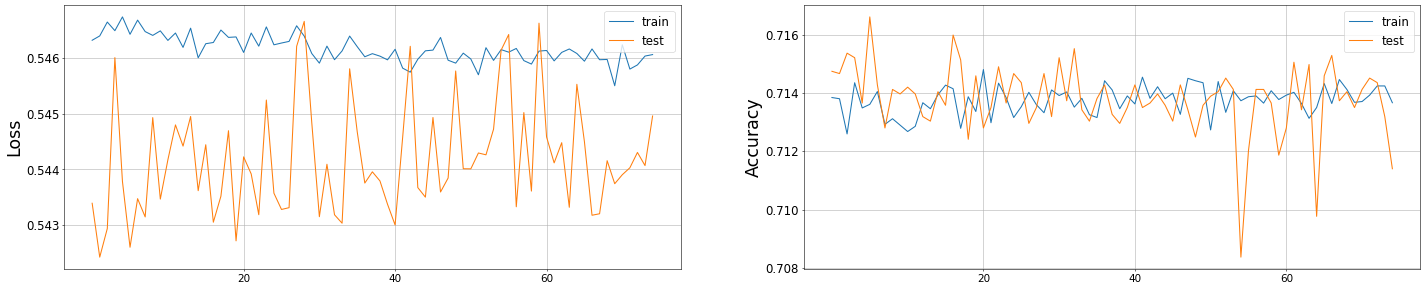

In [29]:
"""
looking at the train/test loss and accuracy over the epochs
"""

width_in_inches = 35
height_in_inches = 7
dots_per_inch = 50

plt.figure(
    figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)

# PICK THE FOLD
fold = 5

# plot loss during training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['loss'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(loc='upper right', fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/leaveoneoutencoding/train.png')

# plot accuracy during training
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['accuracy'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/leaveoneoutencoding/test.png')

plt.show()

671/671 [==============================] - 1s 1ms/step
[[    1 10267]
 [    1 11182]]


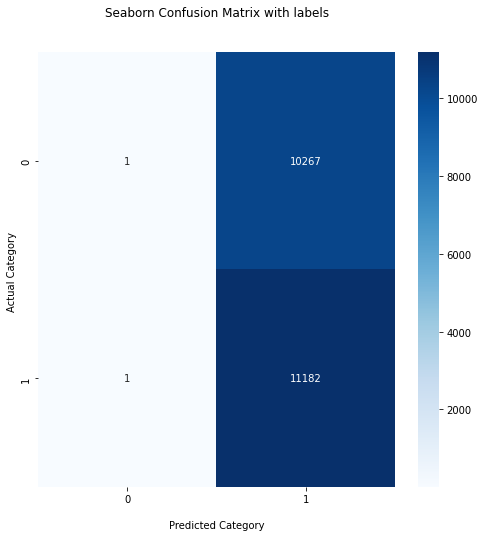

              precision    recall  f1-score   support

           0       0.50      0.00      0.00     10268
           1       0.52      1.00      0.69     11183

    accuracy                           0.52     21451
   macro avg       0.51      0.50      0.34     21451
weighted avg       0.51      0.52      0.36     21451



In [30]:


"""
printing the confusion matrix
"""

preds = load_model(filepath).predict(test_x).squeeze()

assert preds.shape == test_y.shape, 'The shapes of the two tensors are unequal'

print(confusion_matrix(test_y, np.round(preds)))
cf_matrix = confusion_matrix(test_y, np.round(preds))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(test_y, np.round(preds)))



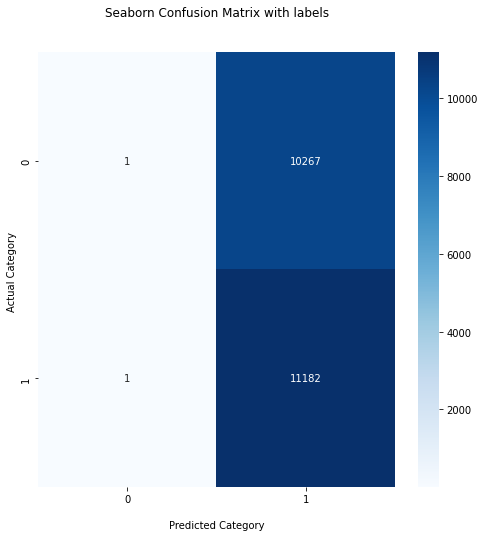

In [31]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(test_y, np.round(preds))

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

In [32]:
# Random Forest model
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
forest = RandomForestClassifier(max_depth=5)

# fit the model 
forest.fit(train_x, train_y)

RandomForestClassifier(max_depth=5)

In [33]:

#predicting the target value from the model for the samples
y_test_forest = forest.predict(test_x)


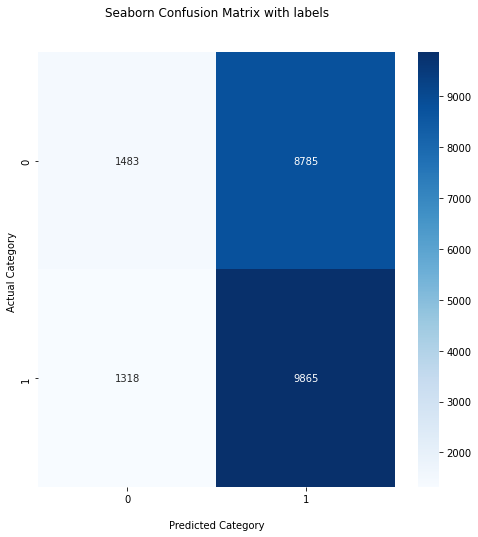

              precision    recall  f1-score   support

           0       0.14      0.53      0.23      2801
           1       0.88      0.53      0.66     18650

    accuracy                           0.53     21451
   macro avg       0.51      0.53      0.44     21451
weighted avg       0.79      0.53      0.60     21451



In [34]:
cf_matrix = confusion_matrix(test_y, y_test_forest)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()


print(classification_report(y_test_forest, test_y))

In [35]:
# Decision Tree model 
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth = 5)
# fit the model 
tree.fit(train_x, train_y)

#predicting the target value from the model for the samples
y_test_tree = tree.predict(test_x)

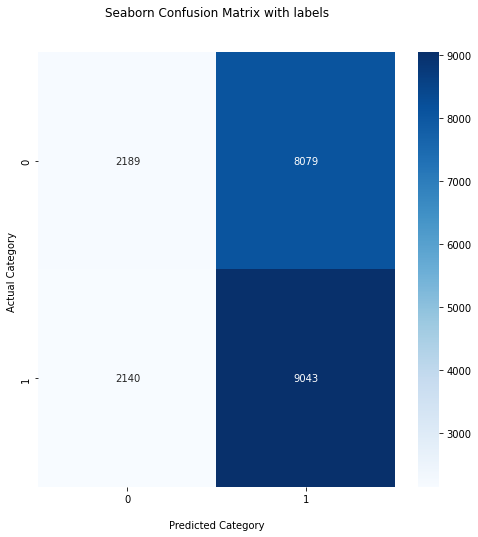

              precision    recall  f1-score   support

           0       0.21      0.51      0.30      4329
           1       0.81      0.53      0.64     17122

    accuracy                           0.52     21451
   macro avg       0.51      0.52      0.47     21451
weighted avg       0.69      0.52      0.57     21451



In [36]:

cf_matrix = confusion_matrix(test_y, y_test_tree)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(y_test_tree, test_y))

In [37]:
#XGBoost Classification model
from xgboost import XGBClassifier

# instantiate the model
xgb = XGBClassifier(learning_rate=0.4,max_depth=7)
#fit the model
xgb.fit(train_x, train_y)

#predicting the target value from the model for the samples
y_xgb = xgb.predict(test_x)

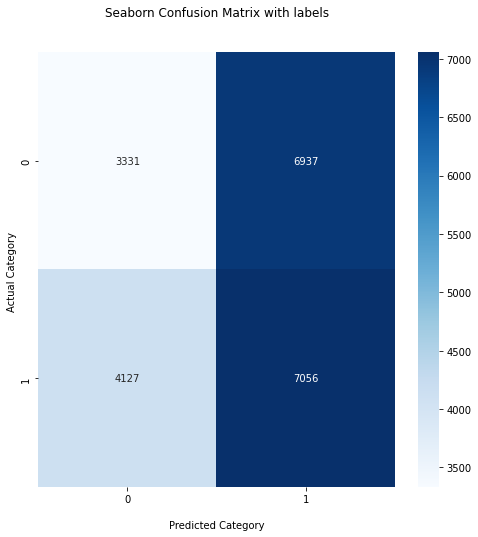

              precision    recall  f1-score   support

           0       0.32      0.45      0.38      7458
           1       0.63      0.50      0.56     13993

    accuracy                           0.48     21451
   macro avg       0.48      0.48      0.47     21451
weighted avg       0.52      0.48      0.50     21451



In [38]:
cf_matrix = confusion_matrix(test_y, y_xgb)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(y_xgb, test_y))

Test 2.1 - Frequency Encoding on venue categories (all 10 variables).

In [39]:
# combined data of dumpsites and non-dumpsites in train and test sets

datad = pd.concat([final, final_random], axis=0)

datad_test = pd.concat([final_test, final_random_test], axis=0)

In [40]:
datad.shape, datad_test.shape

((89346, 28), (22330, 28))

In [41]:
"""
Applying an encoding onto the 10 different columns (#thMostFreq and #thClosest) categorical variables
"""

columns = ['1stMostFreq', '2ndMostFreq', '3rdMostFreq', '4thMostFreq', '5thMostFreq', '1stClosest', '2ndClosest', '3rdClosest', '4thClosest', '5thClosest']

for col in columns: 
  freq = datad.groupby(col).size() / len(datad)
  
  # training
  datad[col + 'frequency_enc'] = datad[col].map(freq)
  datad.drop([col], axis=1, inplace=True)
  
  #testing
  datad_test[col + 'frequency_enc'] = datad_test[col].map(freq)
  datad_test.drop([col], axis=1, inplace=True)

datad.drop(['TrashOutID', 'Lat', 'Lon'], axis=1, inplace=True)
datad_test.drop(['TrashOutID', 'Lat', 'Lon'], axis=1, inplace=True)

# try frequency encoding as in this article
# https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02


datad.head()

,Distance to Road,Distance to Minor Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,Africa,Asia,Australia,...,1stMostFreqfrequency_enc,2ndMostFreqfrequency_enc,3rdMostFreqfrequency_enc,4thMostFreqfrequency_enc,5thMostFreqfrequency_enc,1stClosestfrequency_enc,2ndClosestfrequency_enc,3rdClosestfrequency_enc,4thClosestfrequency_enc,5thClosestfrequency_enc
0,152.071468,47.383710,3553.60,0.317897,341,5,654.2,1,0,0,...,0.022195,0.001947,0.029626,0.000034,0.003828,0.034238,0.015345,0.000022,0.001097,0.003414
1,188.271287,10.439037,1704.99,0.714321,1500,0,3000.0,1,0,0,...,0.302700,0.423824,0.508417,0.586103,0.681116,0.302700,0.415844,0.491807,0.547243,0.644394
2,473.134755,0.000000,3842.15,0.494658,496,4,620.0,1,0,0,...,0.001623,0.001701,0.029626,0.001601,0.681116,0.034238,0.002261,0.001231,0.001623,0.644394
3,2500.000000,0.000000,11928.59,0.327302,61,1,61.0,1,0,0,...,0.004365,0.423824,0.508417,0.586103,0.681116,0.004880,0.415844,0.491807,0.547243,0.644394
4,6.404573,16.189577,314.45,0.923777,1500,0,3000.0,1,0,0,...,0.302700,0.423824,0.508417,0.586103,0.681116,0.302700,0.415844,0.491807,0.547243,0.644394


In [42]:
"""
removing any null values in other variables
"""

print(datad.shape, datad_test.shape)

datad.dropna(inplace=True)
datad_test.dropna(inplace=True)

datad.shape, datad_test.shape

(89346, 25) (22330, 25)


((85790, 25), (21303, 25))

Building a Model (frequency encoding)

In [43]:


"""
training and testing separation
"""

X = datad.drop(['target'], axis=1).to_numpy()
Y = datad['target'].to_numpy()

test_x = datad_test.drop(['target'], axis=1).to_numpy()
test_y = datad_test['target'].to_numpy()

using_kfold = True

if not using_kfold:
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    stratify=Y,
                                                    random_state=111)
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")

else:
  X_train = X
  Y_train = Y
  print(f"X_train is {X_train.shape}", f"Y_train is {Y_train.shape}")



X_train is (85790, 24) Y_train is (85790,)


In [44]:
"""
normalizing the continuous variables
"""

scaler = StandardScaler()

scaler.fit(X_train[:, :6])

X_train[:, :6] = scaler.transform(X_train[:, :6])

if not using_kfold:
  X_test[:, :6] = scaler.transform(X_test[:, :6]) 
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")
else:
  X_train.shape

In [45]:
"""
building the model
"""

x_input = Input(shape=(X_train.shape[-1],), name='input_layer')

x = Dense(units=32, activation='relu', name=f'dense_1',
          kernel_regularizer=regularizers.l2(1e-4))(x_input)

# x = Dropout(rate=0.2, name=f'dropout_1')(x)

for i, unit in enumerate([32, 32], start=2):
    x = Dense(units=unit, activation='relu', name=f'dense_{i}',
              kernel_regularizer=regularizers.l2(1e-4))(x)
    # x = Dropout(rate=0.2, name=f'dropout_{i}')(x)
    # x = BatchNormalization(name=f'batchnorm_{i}')(x)

out = Dense(units=1, activation='sigmoid', name='output_layer')(x)

model = Model(inputs=x_input, outputs=out, name='Dumpsite_Prediction_Model')

# saving the model graph and seeing the architecture 
plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/frequencyencoding_nn_graph.png')

model.summary()

Model: "Dumpsite_Prediction_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 24)]              0         
                                                                 
 dense_1 (Dense)             (None, 32)                800       
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


Using K-Fold for better learning

In [46]:
"""
using the sklearn library to split the training data
into folds of training and validation splits
"""

n_split=10

fold = StratifiedShuffleSplit(n_splits=n_split, test_size=0.15,
                              random_state=111)

train_acc=[]
train_loss=[]
val_acc=[]
val_loss=[]
hists = []

fold.get_n_splits(X_train, Y_train)

10

In [47]:
#Training for Frequency encoding
"""
compiling and fitting
"""

filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/frequencyencoding/curr_model.h5'

checkpoint = ModelCheckpoint(filepath=filepath_curr, monitor='val_accuracy', save_best_only=True)

opts = Adam(learning_rate=0.001, epsilon=1e-8, decay=0.0001)

# model will begin training with previously trained weights
try:
    model.load_weights(filepath_curr)
    print('Same architecture as before.\n\n')
except:
    print('Model architecture has been changed. No weights loaded.\n\n')

i = 1 # counter for print statement

if not using_kfold:
  model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(
      X_train,
      Y_train,
      batch_size=128,
      epochs=75,
      validation_data=(X_test, Y_test),
      callbacks=[checkpoint],
      verbose=2
  )
else:
  for train_index, val_index in fold.split(X_train, Y_train):

      train_x, val_x = X_train[train_index], X_train[val_index]
      train_y, val_y = Y_train[train_index], Y_train[val_index]

      model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
          
      history = model.fit(
          train_x,
          train_y,
          batch_size=128,
          epochs=75,
          validation_data=(val_x, val_y),
          callbacks=[checkpoint],
          verbose=0
      )

      curr_train_acc = round(model.evaluate(train_x, train_y, verbose=0)[1]*100, 2)
      curr_val_acc = round(model.evaluate(val_x, val_y, verbose=0)[1]*100, 2)

      curr_train_loss = model.evaluate(train_x, train_y, verbose=0)[0]
      curr_val_loss = model.evaluate(val_x, val_y, verbose=0)[0]

      print("-"*75)
      print(f"Fold {i}: train acc = {curr_train_acc}%")
      print(f"Fold {i}: val acc = {curr_val_acc}%")
      print("-"*75 + "\n\n")

      train_acc.append(curr_train_acc)
      val_acc.append(curr_val_acc)
      train_loss.append(curr_train_loss)
      val_loss.append(curr_val_loss)

      i += 1

Same architecture as before.


---------------------------------------------------------------------------
Fold 1: train acc = 64.73%
Fold 1: val acc = 65.24%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 2: train acc = 64.65%
Fold 2: val acc = 63.85%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 3: train acc = 65.29%
Fold 3: val acc = 65.41%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 4: train acc = 65.35%
Fold 4: val acc = 65.16%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 5: train acc = 65.32%
Fold 5: val acc = 65.69%
-----------------

In [48]:

#Evaluating average accuracy and loss after K-Fold

if using_kfold:
  for i, v in enumerate(train_acc, start=0):
    print('-'*50)
    print(f'Fold {i+1} - Train Loss: {train_loss[i]} - Train Accuracy: {train_acc[i]}%')
    print(f'Fold {i+1} - Validation Loss: {val_loss[i]} - Validation Accuracy: {val_acc[i]}%')

  print('-'*50)

  print('\n\nAverage scores for all folds:\n\n')
  # training
  print(f'Train Accuracy: {round(np.mean(train_acc), 2)} +- {round(np.std(train_acc), 2)}')
  print(f'Train Loss: {round(np.mean(train_loss), 3)}')
  # validation
  print(f'\n\nTest Accuracy: {round(np.mean(val_acc), 2)} +- {round(np.std(val_acc), 2)}')
  print(f'Test Loss: {round(np.mean(val_loss), 3)}')



--------------------------------------------------
Fold 1 - Train Loss: 0.6239250302314758 - Train Accuracy: 64.73%
Fold 1 - Validation Loss: 0.6243875622749329 - Validation Accuracy: 65.24%
--------------------------------------------------
Fold 2 - Train Loss: 0.6231120824813843 - Train Accuracy: 64.65%
Fold 2 - Validation Loss: 0.6312901973724365 - Validation Accuracy: 63.85%
--------------------------------------------------
Fold 3 - Train Loss: 0.6191246509552002 - Train Accuracy: 65.29%
Fold 3 - Validation Loss: 0.6172323226928711 - Validation Accuracy: 65.41%
--------------------------------------------------
Fold 4 - Train Loss: 0.617876410484314 - Train Accuracy: 65.35%
Fold 4 - Validation Loss: 0.6186568140983582 - Validation Accuracy: 65.16%
--------------------------------------------------
Fold 5 - Train Loss: 0.617771327495575 - Train Accuracy: 65.32%
Fold 5 - Validation Loss: 0.6174547672271729 - Validation Accuracy: 65.69%
-----------------------------------------------

In [49]:
"""
this code takes care of saving the new model only if its accuracy is better than
that of the last model
"""

filepath = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/frequencyencoding/best_model.h5'
filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/frequencyencoding/curr_model.h5'


if os.path.exists(filepath):
  prev_model = load_model(filepath)
  curr_model = load_model(filepath_curr)

  prev_acc = prev_model.evaluate(test_x, test_y, verbose=0)[1]
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]

  if curr_acc > prev_acc:
    print("There was a previous model saved.\n")
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    curr_model.save(filepath)
    print('\nNew model is saved.')
  else:
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    print('Old model is kept.')

else: # if this is the first time saving the model
  model.save(filepath)
  curr_model = load_model(filepath)
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]
  print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
  print('\nFirst time model is saved.')

Previous test accuracy: 52.17%
Current test accuracy: 52.01%
Old model is kept.


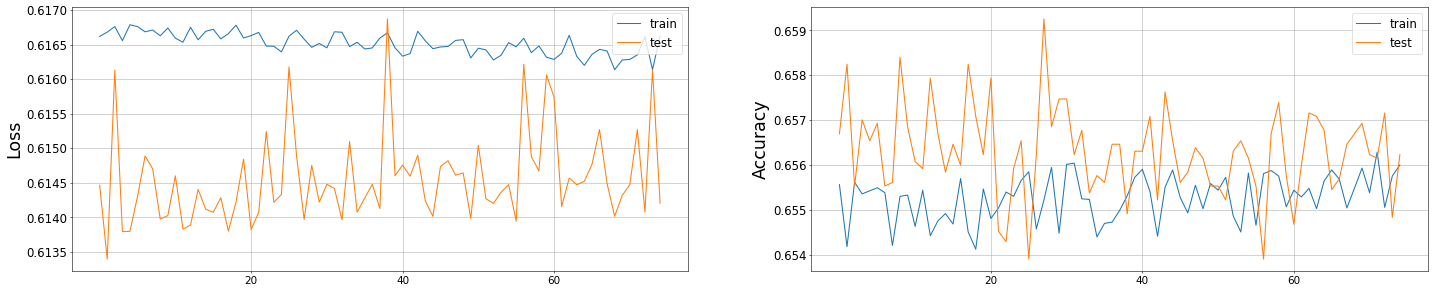

In [50]:
"""
looking at the train/test loss and accuracy over the epochs
"""

width_in_inches = 35
height_in_inches = 7
dots_per_inch = 50

plt.figure(
    figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)

# PICK THE FOLD
fold = 5

# plot loss during training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['loss'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(loc='upper right', fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/frequencyencoding/train.png')

# plot accuracy during training
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['accuracy'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/frequencyencoding/test.png')

plt.show()

666/666 [==============================] - 1s 2ms/step
[[    0 10190]
 [    0 11113]]


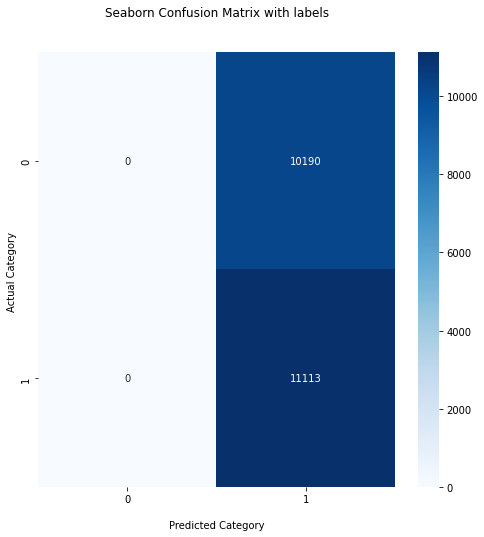

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10190
           1       0.52      1.00      0.69     11113

    accuracy                           0.52     21303
   macro avg       0.26      0.50      0.34     21303
weighted avg       0.27      0.52      0.36     21303



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
"""
printing the confusion matrix
"""

preds = load_model(filepath).predict(test_x).squeeze()

assert preds.shape == test_y.shape, 'The shapes of the two tensors are unequal'

print(confusion_matrix(test_y, np.round(preds)))
cf_matrix = confusion_matrix(test_y, np.round(preds))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(test_y, np.round(preds)))

In [52]:
# Random Forest model
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
forest = RandomForestClassifier(max_depth=5)

# fit the model 
forest.fit(train_x, train_y)

#predicting the target value from the model for the samples
y_test_forest = forest.predict(test_x)

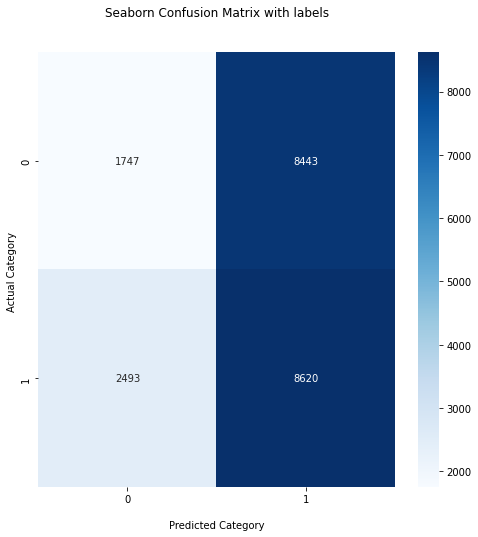

              precision    recall  f1-score   support

           0       0.17      0.41      0.24      4240
           1       0.78      0.51      0.61     17063

    accuracy                           0.49     21303
   macro avg       0.47      0.46      0.43     21303
weighted avg       0.66      0.49      0.54     21303



In [53]:

cf_matrix = confusion_matrix(test_y,y_test_forest )
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(y_test_forest, test_y))

In [54]:
# Decision Tree model 
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth = 5)
# fit the model 
tree.fit(train_x, train_y)

#predicting the target value from the model for the samples
y_test_tree = tree.predict(test_x)

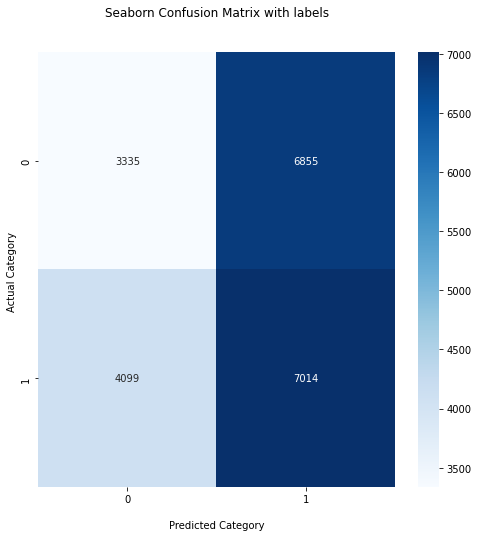

              precision    recall  f1-score   support

           0       0.33      0.45      0.38      7434
           1       0.63      0.51      0.56     13869

    accuracy                           0.49     21303
   macro avg       0.48      0.48      0.47     21303
weighted avg       0.53      0.49      0.50     21303



In [55]:
cf_matrix = confusion_matrix(test_y,y_test_tree)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(y_test_tree, test_y))

In [56]:
#XGBoost Classification model
from xgboost import XGBClassifier

# instantiate the model
xgb = XGBClassifier(learning_rate=0.4,max_depth=7)
#fit the model
xgb.fit(train_x, train_y)

#predicting the target value from the model for the samples
y_xgb = xgb.predict(test_x)

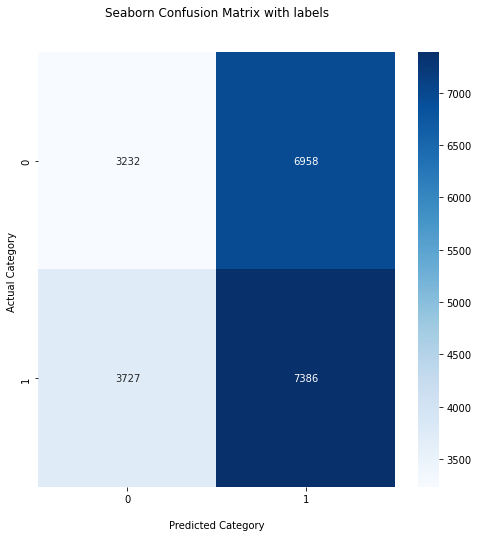

              precision    recall  f1-score   support

           0       0.32      0.46      0.38      6959
           1       0.66      0.51      0.58     14344

    accuracy                           0.50     21303
   macro avg       0.49      0.49      0.48     21303
weighted avg       0.55      0.50      0.51     21303



In [57]:
cf_matrix = confusion_matrix(test_y,y_xgb)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(y_xgb, test_y))

Test 2.2 - Mean Encoding on venue categories (all 10 variables).

In [58]:
datam = pd.concat([final, final_random], axis=0)

datam_test = pd.concat([final_test, final_random_test], axis=0)

In [59]:
# Helper Class for Testing out different encodings


class MultiColumnEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit_transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        given encoder. If no columns specified, transforms all
        columns in X.
        '''
        mean = X['target'].mean()
        if self.columns is not None:
            for col in self.columns:
                agg= X.groupby(col)['target'].agg(['count','mean'])
                counts=agg['count']
                means=agg['mean']
                weight=100
                smooth = (counts*means +weight *mean) / (counts + weight)
                X.loc[:,col+'_encoding'] = X[col].map(smooth)
        else:
            for col in X.columns:
                agg= X.groupby(col)['target'].agg(['count','mean'])
                counts=agg['count']
                means=agg['mean']
                weight=100
                smooth = (counts*means +weight *mean) / (counts + weight)
                X.loc[:,col+'_encoding'] = X[col].map(smooth)
        X.drop(self.columns,axis=1,inplace=True)
        return X

columns =['1stMostFreq','2ndMostFreq','3rdMostFreq','4thMostFreq','5thMostFreq','1stClosest','2ndClosest','3rdClosest',
          '4thClosest','5thClosest']
mc_class =MultiColumnEncoder(columns)

In [60]:
#Applying mean encoding to venue category categorical variables


datam = mc_class.fit_transform(datam)
datam.drop(['Lat', 'Lon', 'TrashOutID'], axis=1, inplace=True)

datam_test = mc_class.fit_transform(datam_test)
datam_test.drop(['Lat', 'Lon', 'TrashOutID'], axis=1, inplace=True)

datam.dropna(inplace=True)
datam_test.dropna(inplace=True)

datam.head()

,Distance to Road,Distance to Minor Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,Africa,Asia,Australia,...,1stMostFreq_encoding,2ndMostFreq_encoding,3rdMostFreq_encoding,4thMostFreq_encoding,5thMostFreq_encoding,1stClosest_encoding,2ndClosest_encoding,3rdClosest_encoding,4thClosest_encoding,5thClosest_encoding
0,152.071468,47.383710,3553.60,0.317897,341,5,654.2,1,0,0,...,0.592505,0.664920,0.513356,0.516389,0.622597,0.531873,0.540577,0.511647,0.521152,0.494291
1,188.271287,10.439037,1704.99,0.714321,1500,0,3000.0,1,0,0,...,0.455781,0.465488,0.472997,0.479476,0.486444,0.455781,0.465136,0.471633,0.476021,0.482890
2,473.134755,0.000000,3842.15,0.494658,496,4,620.0,1,0,0,...,0.494645,0.627730,0.513356,0.605712,0.486444,0.531873,0.464199,0.510419,0.523216,0.482890
3,2500.000000,0.000000,11928.59,0.327302,61,1,61.0,1,0,0,...,0.537118,0.465488,0.472997,0.479476,0.486444,0.530202,0.465136,0.471633,0.476021,0.482890
4,6.404573,16.189577,314.45,0.923777,1500,0,3000.0,1,0,0,...,0.455781,0.465488,0.472997,0.479476,0.486444,0.455781,0.465136,0.471633,0.476021,0.482890


In [61]:

#Building a Model(mean Encoding)

"""
training and testing separation
"""

X = datam.drop(['target'], axis=1).to_numpy()
Y = datam['target'].to_numpy()

test_x = datam_test.drop(['target'], axis=1).to_numpy()
test_y = datam_test['target'].to_numpy()

using_kfold = True

if not using_kfold:
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    stratify=Y,
                                                    random_state=111)
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")

else:
  X_train = X
  Y_train = Y
  print(f"X_train is {X_train.shape}", f"Y_train is {Y_train.shape}")



X_train is (85790, 24) Y_train is (85790,)


In [62]:
"""
normalizing the continuous variables
"""

scaler = StandardScaler()

scaler.fit(X_train[:, :6])

X_train[:, :6] = scaler.transform(X_train[:, :6])

if not using_kfold:
  X_test[:, :6] = scaler.transform(X_test[:, :6]) 
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")
else:
  X_train.shape

In [63]:
"""
building the model
"""

x_input = Input(shape=(X_train.shape[-1],), name='input_layer')

x = Dense(units=32, activation='relu', name=f'dense_1',
          bias_regularizer=regularizers.l2(1e-2),
          activity_regularizer=regularizers.l2(1e-3))(x_input)

# x = Dropout(rate=0.5, name=f'dropout_1')(x)

for i, unit in enumerate([32, 32], start=2):
    # x = Dropout(rate=0.5, name=f'dropout_{i}')(x)
    # x = BatchNormalization(name=f'batchnorm_{i}')(x)
    x = Dense(units=unit, activation='relu', name=f'dense_{i}',
              bias_regularizer=regularizers.l2(1e-2),
              activity_regularizer=regularizers.l2(1e-3))(x)

out = Dense(units=1, activation='sigmoid', name='output_layer')(x)

model = Model(inputs=x_input, outputs=out, name='Dumpsite_Prediction_Model')

# saving the model graph and seeing the architecture 
plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/Official folder for Trashout/Task_1/models_final_model_meanencoding_nn_graph.png')

model.summary()

Model: "Dumpsite_Prediction_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 24)]              0         
                                                                 
 dense_1 (Dense)             (None, 32)                800       
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [64]:

#Using K-Fold for better learning

"""
using the sklearn library to split the training data
into folds of training and validation splits
"""

n_split=2

fold = StratifiedShuffleSplit(n_splits=n_split, test_size=0.15,
                              random_state=111)

train_acc=[]
train_loss=[]
val_acc=[]
val_loss=[]

fold.get_n_splits(X_train, Y_train)



2

In [65]:

#Training for Mean encoding

"""
compiling and fitting
"""

filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/meanencoding/curr_model.h5'

checkpoint = ModelCheckpoint(filepath=filepath_curr, monitor='val_accuracy', save_best_only=True)

opts = Adam(learning_rate=0.001, epsilon=1e-8, decay=0.0001)

# model will begin training with previously trained weights
try:
    model.load_weights(filepath_curr)
    print('Same architecture as before.\n\n')
except:
    print('Model architecture has been changed. No weights loaded.\n\n')

i = 1 # counter for print statement

if not using_kfold:
  model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(
      X_train,
      Y_train,
      batch_size=128,
      epochs=75,
      validation_data=(X_test, Y_test),
      callbacks=[checkpoint],
      verbose=2
  )
else:
  for train_index, val_index in fold.split(X_train, Y_train):

      train_x, val_x = X_train[train_index], X_train[val_index]
      train_y, val_y = Y_train[train_index], Y_train[val_index]

      model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
          
      history = model.fit(
          train_x,
          train_y,
          batch_size=128,
          epochs=75,
          validation_data=(val_x, val_y),
          callbacks=[checkpoint],
          verbose=0
      )

      curr_train_acc = round(model.evaluate(train_x, train_y, verbose=0)[1]*100, 2)
      curr_val_acc = round(model.evaluate(val_x, val_y, verbose=0)[1]*100, 2)

      curr_train_loss = model.evaluate(train_x, train_y, verbose=0)[0]
      curr_val_loss = model.evaluate(val_x, val_y, verbose=0)[0]

      print("-"*75)
      print(f"Fold {i}: train acc = {curr_train_acc}%")
      print(f"Fold {i}: val acc = {curr_val_acc}%")
      print("-"*75 + "\n\n")

      train_acc.append(curr_train_acc)
      val_acc.append(curr_val_acc)
      train_loss.append(curr_train_loss)
      val_loss.append(curr_val_loss)

      i += 1

#

Same architecture as before.


---------------------------------------------------------------------------
Fold 1: train acc = 64.22%
Fold 1: val acc = 64.5%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 2: train acc = 64.71%
Fold 2: val acc = 64.11%
---------------------------------------------------------------------------




In [66]:

#Evaluating average accuracy and loss after K-Fold

if using_kfold:
  for i, v in enumerate(train_acc, start=0):
    print('-'*50)
    print(f'Fold {i+1} - Train Loss: {train_loss[i]} - Train Accuracy: {train_acc[i]}%')
    print(f'Fold {i+1} - Validation Loss: {val_loss[i]} - Validation Accuracy: {val_acc[i]}%')

  print('-'*50)

  print('\n\nAverage scores for all folds:\n\n')
  # training
  print(f'Train Accuracy: {round(np.mean(train_acc), 2)} +- {round(np.std(train_acc), 2)}')
  print(f'Train Loss: {round(np.mean(train_loss), 3)}')
  # validation
  print(f'\n\nTest Accuracy: {round(np.mean(val_acc), 2)} +- {round(np.std(val_acc), 2)}')
  print(f'Test Loss: {round(np.mean(val_loss), 3)}')



--------------------------------------------------
Fold 1 - Train Loss: 0.6096712946891785 - Train Accuracy: 64.22%
Fold 1 - Validation Loss: 0.608780562877655 - Validation Accuracy: 64.5%
--------------------------------------------------
Fold 2 - Train Loss: 0.6064779162406921 - Train Accuracy: 64.71%
Fold 2 - Validation Loss: 0.6093078255653381 - Validation Accuracy: 64.11%
--------------------------------------------------


Average scores for all folds:


Train Accuracy: 64.46 +- 0.24
Train Loss: 0.608


Test Accuracy: 64.31 +- 0.2
Test Loss: 0.609


In [67]:
"""
this code takes care of saving the new model only if its accuracy is better than
that of the last model
"""

filepath = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/meanencoding/best_model.h5'
filepath_curr = '/content/drive/MyDrive/Official folder for Trashout/Task_1/models/meanencoding/curr_model.h5'


if os.path.exists(filepath):
  prev_model = load_model(filepath)
  curr_model = load_model(filepath_curr)

  prev_acc = prev_model.evaluate(test_x, test_y, verbose=0)[1]
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]

  if curr_acc > prev_acc:
    print("There was a previous model saved.\n")
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    curr_model.save(filepath)
    print('\nNew model is saved.')
  else:
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    print('Old model is kept.')

else: # if this is the first time saving the model
  model.save(filepath)
  curr_model = load_model(filepath)
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]
  print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
  print('\nFirst time model is saved.')

There was a previous model saved.

Previous test accuracy: 49.63%
Current test accuracy: 52.65%

New model is saved.


671/671 [==============================] - 1s 2ms/step
[[4790 5478]
 [4679 6504]]


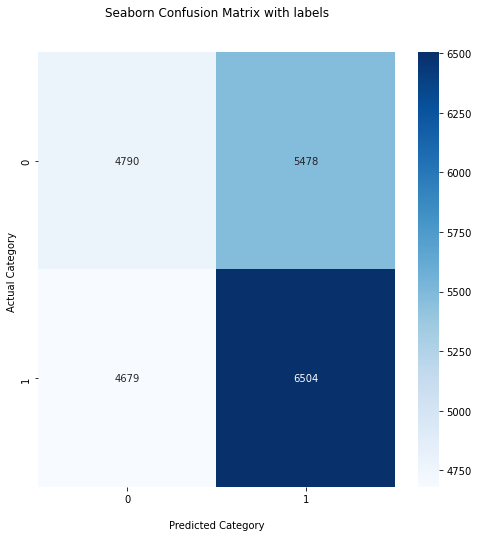

              precision    recall  f1-score   support

           0       0.51      0.47      0.49     10268
           1       0.54      0.58      0.56     11183

    accuracy                           0.53     21451
   macro avg       0.52      0.52      0.52     21451
weighted avg       0.53      0.53      0.53     21451



In [68]:
"""
printing the confusion matrix
"""

preds = load_model(filepath).predict(test_x).squeeze()

assert preds.shape == test_y.shape, 'The shapes of the two tensors are unequal'

print(confusion_matrix(test_y, np.round(preds)))
cf_matrix = confusion_matrix(test_y, np.round(preds))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(test_y, np.round(preds)))

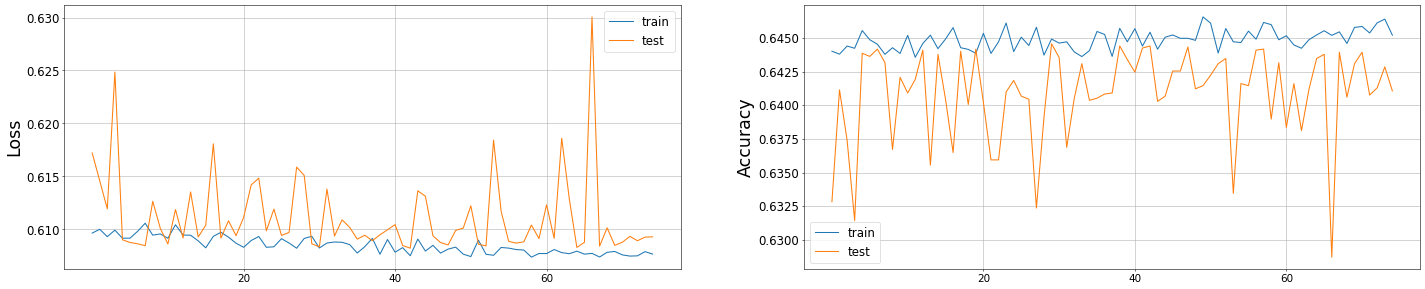

In [69]:
"""
looking at the train/test loss and accuracy over the epochs
"""

width_in_inches = 35
height_in_inches = 7
dots_per_inch = 50

plt.figure(
    figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)

# PICK THE FOLD
fold = 5

# plot loss during training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['loss'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(loc='upper right', fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/meanencoding/train.png')

# plot accuracy during training
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['accuracy'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/meanencoding/test.png')

plt.show()

In [70]:
# Random Forest model
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
forest = RandomForestClassifier(max_depth=5)

# fit the model 
forest.fit(train_x, train_y)

#predicting the target value from the model for the samples
y_test_forest = forest.predict(test_x)

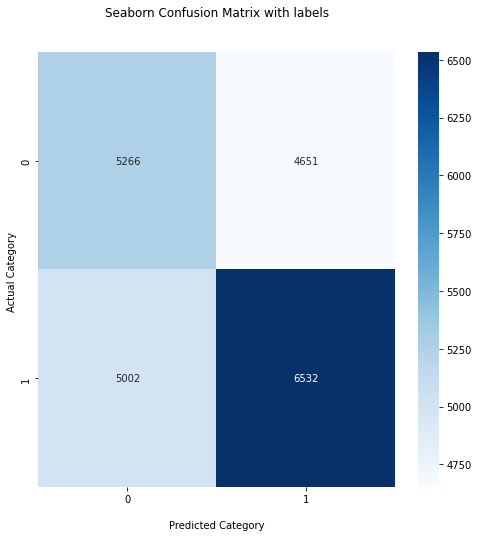

              precision    recall  f1-score   support

           0       0.51      0.53      0.52      9917
           1       0.58      0.57      0.58     11534

    accuracy                           0.55     21451
   macro avg       0.55      0.55      0.55     21451
weighted avg       0.55      0.55      0.55     21451



In [71]:

cf_matrix = confusion_matrix(y_test_forest, test_y)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(y_test_forest, test_y))

In [72]:
# Decision Tree model 
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth = 5)
# fit the model 
tree.fit(train_x, train_y)

#predicting the target value from the model for the samples
y_test_tree = tree.predict(test_x)

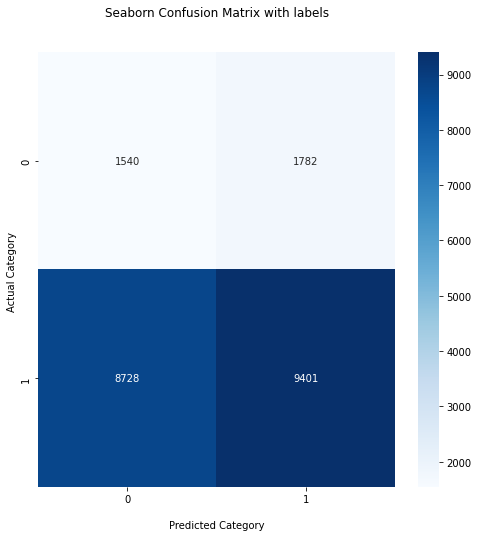

              precision    recall  f1-score   support

           0       0.15      0.46      0.23      3322
           1       0.84      0.52      0.64     18129

    accuracy                           0.51     21451
   macro avg       0.50      0.49      0.43     21451
weighted avg       0.73      0.51      0.58     21451



In [73]:

cf_matrix = confusion_matrix(y_test_tree, test_y)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(y_test_tree, test_y))

In [74]:
#XGBoost Classification model
from xgboost import XGBClassifier

# instantiate the model
xgb = XGBClassifier(learning_rate=0.4,max_depth=7)
#fit the model
xgb.fit(train_x, train_y)

#predicting the target value from the model for the samples
y_xgb = xgb.predict(test_x)

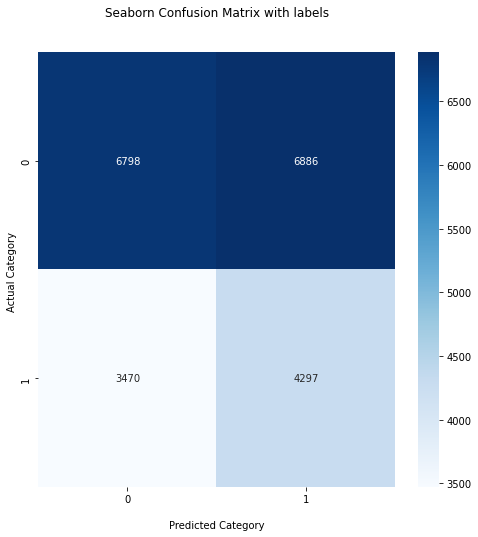

              precision    recall  f1-score   support

           0       0.66      0.50      0.57     13684
           1       0.38      0.55      0.45      7767

    accuracy                           0.52     21451
   macro avg       0.52      0.53      0.51     21451
weighted avg       0.56      0.52      0.53     21451



In [75]:
cf_matrix = confusion_matrix(y_xgb, test_y)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(y_xgb, test_y))

ABANDONED Test 3 - distance to roads ordinal encoding
ABANDONED - the performance accuracy of this variation was far below other models. The continuity of the distance to roads variable is a critically important variable for a good model.

In [76]:
# training data
final = pd.read_csv('/content/Illegal dumpsites data/Complete_dumpSites.csv')
print(f"final has shape {final.shape}")

final_random = pd.read_csv('/content/Illegal dumpsites data/Complete_randomPoints_1km.csv')
print(f"final_random has shape {final_random.shape}")

# testing data
final_test = pd.read_csv('/content/Illegal dumpsites data/Complete_dumpSites_Test.csv')
print(f"final_test has shape {final_test.shape}")

final_random_test = pd.read_csv('/content/Illegal dumpsites data/Complete_randomPoints_1km_Test.csv')
print(f"final_random_test has shape {final_random_test.shape}")

final has shape (44881, 21)
final_random has shape (44545, 21)
final_test has shape (11217, 21)
final_random_test has shape (11133, 21)



Generate Distance to Road Categories

Create 'roadDstBin' column based on following distance categories:

    0 --> 0 <= x < 15,
    1 --> 15 <= x < 70,
    2 --> 70 <= x

Working on 4 datastes:

    final
    final_random
    final_test
    final_random_test



In [77]:
final.loc[final['Distance to Road']<15,'RoadDstBin'] = 0
final.loc[(final['Distance to Road']>=15) & (final['Distance to Road']<70),'RoadDstBin'] = 1
final.loc[final['Distance to Road']>70,'RoadDstBin'] = 2

final

,TrashOutID,Lat,Lon,Continent,Distance to Road,Distance to Minor Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,...,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest,RoadDstBin
0,57836,-26.182135,27.989881,Africa,152.071468,47.383710,3553.60,0.317897,341,5,...,Tennis Court,Restaurant,Student Center,Bus Station,Restaurant,Bar,Student Center,Tennis Court,Bus Station,2.0
1,57831,-28.466159,28.855491,Africa,188.271287,10.439037,1704.99,0.714321,1500,0,...,None,None,None,None,None,None,None,None,None,2.0
2,57830,-28.514575,28.820169,Africa,473.134755,0.000000,3842.15,0.494658,496,4,...,Beer Garden,Restaurant,Gas Station,None,Restaurant,Gas Station,Auto Workshop,Beer Garden,None,2.0
3,57829,-29.947538,30.915913,Africa,2500.000000,0.000000,11928.59,0.327302,61,1,...,None,None,None,None,Shopping Mall,None,None,None,None,2.0
4,57828,-26.243496,27.696129,Africa,6.404573,16.189577,314.45,0.923777,1500,0,...,None,None,None,None,None,None,None,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44876,3271,-35.500999,-71.702774,South America,770.746839,1.290904,117.51,0.000000,1500,0,...,None,None,None,None,None,None,None,None,None,2.0
44877,2315,4.535037,-74.116149,South America,1.960398,19.162455,6356.60,0.000000,332,5,...,Big Box Store,Shopping Mall,Multiplex,Bus Station,Multiplex,Big Box Store,Shopping Mall,Bus Station,Park,0.0
44878,2280,4.534641,-74.115919,South America,10.899807,58.429164,6356.60,0.000000,319,5,...,Big Box Store,Shopping Mall,Multiplex,Bus Station,Multiplex,Big Box Store,Shopping Mall,Bus Station,Park,0.0
44879,1840,-25.524732,-49.107813,South America,413.127606,0.000000,1088.07,0.772548,581,4,...,Restaurant,Café,Trail,None,Soccer Field,Trail,Restaurant,Café,None,2.0


In [78]:
final_random.loc[final_random['Distance to Road']<15,'RoadDstBin'] = 0
final_random.loc[(final_random['Distance to Road']>=15) & (final_random['Distance to Road']<70),'RoadDstBin'] = 1
final_random.loc[final_random['Distance to Road']>70,'RoadDstBin'] = 2

final_random

,TrashOutID,Lat,Lon,Continent,Distance to Road,Distance to Minor Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,...,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest,RoadDstBin
0,57836,-26.174340,27.985381,Africa,602.532557,64.609295,4436.40,0.596904,420,5,...,Shopping Mall,Supermarket,Tennis Court,Fast Food Restaurant,Tennis Court,Shopping Mall,Fast Food Restaurant,Supermarket,Restaurant,2.0
1,57830,-28.506780,28.815669,Africa,442.621038,199.291785,3341.90,0.561918,634,3,...,Gas Station,Restaurant,None,None,Restaurant,Gas Station,Construction & Landscaping,None,None,2.0
2,57829,-29.938537,30.915913,Africa,218.364338,1.116930,7893.65,0.622818,1500,0,...,None,None,None,None,None,None,None,None,None,2.0
3,57828,-26.247996,27.703924,Africa,104.554359,14.872181,5.65,0.499462,1500,0,...,None,None,None,None,None,None,None,None,None,2.0
4,57813,-26.022700,28.006938,Africa,27.038396,54.044775,3039.87,0.360769,317,41,...,Hotel,Coffee Shop,Shopping Mall,Theater,Department Store,Zoo,Hotel,Comedy Club,Coffee Shop,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44540,3693,-1.452680,-48.513001,South America,11.002949,0.000000,0.00,0.500000,565,20,...,Historic Site,Plaza,Bar,History Museum,River,Bar,Boat or Ferry,Boat or Ferry,Music Venue,0.0
44541,3271,-35.505499,-71.694979,South America,267.431133,991.164582,117.51,0.000000,996,1,...,None,None,None,None,Pet Store,None,None,None,None,2.0
44542,2315,4.539538,-74.108354,South America,4.486192,69.621733,6356.60,0.000000,149,4,...,Grocery Store,Park,None,None,Park,Home Service,Grocery Store,Home Service,None,0.0
44543,2280,4.530140,-74.123714,South America,543.319072,191.152774,6356.60,0.000000,519,5,...,Multiplex,Shopping Mall,Big Box Store,Gas Station,Bus Station,Big Box Store,Shopping Mall,Multiplex,Gas Station,2.0


In [79]:
final_test.loc[final_test['Distance to Road']<15,'RoadDstBin'] = 0
final_test.loc[(final_test['Distance to Road']>=15) & (final_test['Distance to Road']<70),'RoadDstBin'] = 1
final_test.loc[final_test['Distance to Road']>70,'RoadDstBin'] = 2

final_test

,TrashOutID,Lat,Lon,Continent,Distance to Road,Distance to Minor Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,...,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest,RoadDstBin
0,57837,-26.196481,28.050331,Africa,31.210050,22.381337,12718.73,0.840314,332,24,...,Portuguese Restaurant,Shopping Mall,Fried Chicken Joint,Hotel,Art Gallery,Shopping Mall,Convenience Store,Seafood Restaurant,Theater,1.0
1,57801,-25.748739,28.185587,Africa,75.140489,233.391602,16525.11,0.591873,295,25,...,Burger Joint,History Museum,Shopping Mall,Hotel,Café,Portuguese Restaurant,Plaza,Burger Joint,History Museum,2.0
2,57652,-34.123890,18.400695,Africa,278.447749,0.000000,1695.67,0.633405,319,5,...,Gym / Fitness Center,Shopping Mall,Pharmacy,None,Pharmacy,Gym / Fitness Center,Shopping Mall,Fast Food Restaurant,Fast Food Restaurant,2.0
3,57632,-25.415069,28.727566,Africa,2500.000000,18.469547,2119.07,0.643358,1500,0,...,None,None,None,None,None,None,None,None,None,2.0
4,57604,-33.913747,25.602708,Africa,0.000000,114.753524,560.96,0.902579,836,1,...,None,None,None,None,Pizza Place,None,None,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11212,15554,-33.595439,-70.680218,South America,0.000000,21.387025,2616.26,0.095109,524,4,...,Grocery Store,Bus Station,Asian Restaurant,None,Asian Restaurant,Bus Station,Argentinian Restaurant,Grocery Store,None,0.0
11213,15212,-31.414762,-64.241595,South America,7.032035,11.737311,2404.11,0.000000,474,3,...,Breakfast Spot,None,None,None,Grocery Store,Breakfast Spot,Grocery Store,None,None,0.0
11214,10243,-33.042535,-71.552862,South America,384.003987,114.406490,2473.31,0.015364,259,6,...,Stadium,Airport,Gym,Liquor Store,Trail,Stadium,Gym,Plaza,Airport,2.0
11215,8170,-16.508965,-68.119557,South America,20.437213,58.406335,374.20,0.000000,349,41,...,Restaurant,Hotel,Café,Coffee Shop,Tea Room,Hotel,Gym,Café,Italian Restaurant,1.0


In [80]:
final_random_test.loc[final_random_test['Distance to Road']<15,'RoadDstBin'] = 0
final_random_test.loc[(final_random_test['Distance to Road']>=15) & (final_random_test['Distance to Road']<70),'RoadDstBin'] = 1
final_random_test.loc[final_random_test['Distance to Road']>70,'RoadDstBin'] = 2

final_random_test

,TrashOutID,Lat,Lon,Continent,Distance to Road,Distance to Minor Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,...,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest,RoadDstBin
0,57837,-26.191981,28.042536,Africa,38.480960,42.003566,45583.50,0.662325,258,44,...,Fast Food Restaurant,Hotel,Art Gallery,Café,Historic Site,Theater,Art Gallery,Train Station,Hotel,1.0
1,57831,-28.473954,28.859991,Africa,2500.000000,485.686136,2167.54,0.636909,1500,0,...,None,None,None,None,None,None,None,None,None,2.0
2,57817,-26.385727,27.300703,Africa,2500.000000,400.045361,2.17,0.644543,1500,0,...,None,None,None,None,None,None,None,None,None,2.0
3,57765,-24.651315,30.295612,Africa,263.778975,209.563540,106.28,0.534346,847,2,...,Fast Food Restaurant,None,None,None,Fast Food Restaurant,Construction & Landscaping,None,None,None,2.0
4,57755,-26.239470,27.846345,Africa,328.708620,0.000000,13328.54,0.480500,1500,0,...,None,None,None,None,None,None,None,None,None,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11128,16151,7.101610,-73.141971,South America,14.414909,25.656438,4447.68,0.000000,876,2,...,Park,None,None,None,American Restaurant,Park,None,None,None,0.0
11129,15721,6.981634,-73.037247,South America,684.022957,414.560859,438.21,0.000000,656,5,...,Farm,Pool,Arts & Entertainment,Resort,Arts & Entertainment,Farm,Restaurant,Resort,Pool,2.0
11130,11151,5.791730,-55.224376,South America,857.373611,0.000000,3133.64,0.509941,339,1,...,None,None,None,None,Grocery Store,None,None,None,None,2.0
11131,7970,-40.311290,-72.641725,South America,999.063982,NaN,14.26,0.063464,1500,0,...,None,None,None,None,None,None,None,None,None,2.0


In [81]:
# Drop the original Distance to Road column in each dataset
final = final.drop('Distance to Road',axis=1)
final_random = final_random.drop('Distance to Road',axis=1)
final_test = final_test.drop('Distance to Road',axis=1)
final_random_test = final_random_test.drop('Distance to Road',axis=1)

In [82]:
"""
removing null values from Continent variables
"""

final = final[final['Continent'].notna()]
final_random = final_random[final_random['Continent'].notna()]

final_test = final_test[final_test['Continent'].notna()]
final_random_test = final_random_test[final_random_test['Continent'].notna()]

In [83]:
final['Continent'].isnull().any(), final_random['Continent'].isnull().any(), final_test['Continent'].isnull().any(), final_random_test['Continent'].isnull().any()

# great, null values removed from Continent of all four datasets

(False, False, False, False)

In [84]:


final['RoadDstBin'].isnull().any(), final_random['RoadDstBin'].isnull().any(), final_test['RoadDstBin'].isnull().any(), final_random_test['RoadDstBin'].isnull().any()

# great, null values removed from RoadDstBin of all four datasets



(False, False, False, False)

In [85]:
# do we need this / what does this do? 
set(final['RoadDstBin']), set(final_random['RoadDstBin']), set(final_test['RoadDstBin']), set(final_random_test['RoadDstBin'])

({0.0, 1.0, 2.0}, {0.0, 1.0, 2.0}, {0.0, 1.0, 2.0}, {0.0, 1.0, 2.0})

In [86]:
len(set(final['RoadDstBin'])), len(set(final_random['RoadDstBin'])), len(set(final_test['RoadDstBin'])), len(set(final_random_test['RoadDstBin']))

(3, 3, 3, 3)

In [87]:
"""
adding target labels
"""

if 'target' not in final.columns + final_random.columns:
    final['target'] = 1
    final_random['target'] = 0

if 'target' not in final_test.columns + final_random_test.columns:
    final_test['target'] = 1
    final_random_test['target'] = 0

In [88]:


final



,TrashOutID,Lat,Lon,Continent,Distance to Minor Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,...,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest,RoadDstBin,target
0,57836,-26.182135,27.989881,Africa,47.383710,3553.60,0.317897,341,5,654.2,...,Restaurant,Student Center,Bus Station,Restaurant,Bar,Student Center,Tennis Court,Bus Station,2.0,1
1,57831,-28.466159,28.855491,Africa,10.439037,1704.99,0.714321,1500,0,3000.0,...,None,None,None,None,None,None,None,None,2.0,1
2,57830,-28.514575,28.820169,Africa,0.000000,3842.15,0.494658,496,4,620.0,...,Restaurant,Gas Station,None,Restaurant,Gas Station,Auto Workshop,Beer Garden,None,2.0,1
3,57829,-29.947538,30.915913,Africa,0.000000,11928.59,0.327302,61,1,61.0,...,None,None,None,Shopping Mall,None,None,None,None,2.0,1
4,57828,-26.243496,27.696129,Africa,16.189577,314.45,0.923777,1500,0,3000.0,...,None,None,None,None,None,None,None,None,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44876,3271,-35.500999,-71.702774,South America,1.290904,117.51,0.000000,1500,0,3000.0,...,None,None,None,None,None,None,None,None,2.0,1
44877,2315,4.535037,-74.116149,South America,19.162455,6356.60,0.000000,332,5,536.4,...,Shopping Mall,Multiplex,Bus Station,Multiplex,Big Box Store,Shopping Mall,Bus Station,Park,0.0,1
44878,2280,4.534641,-74.115919,South America,58.429164,6356.60,0.000000,319,5,524.0,...,Shopping Mall,Multiplex,Bus Station,Multiplex,Big Box Store,Shopping Mall,Bus Station,Park,0.0,1
44879,1840,-25.524732,-49.107813,South America,0.000000,1088.07,0.772548,581,4,695.0,...,Café,Trail,None,Soccer Field,Trail,Restaurant,Café,None,2.0,1


In [89]:


"""
making the continent into one-hot encoding for both datasets
"""

train_dumpsite_dummies = pd.get_dummies(final['Continent'])
final = pd.concat([final.drop('Continent', axis=1), train_dumpsite_dummies], axis=1)

train_nondumpsite_dummies = pd.get_dummies(final_random['Continent'])
final_random = pd.concat([final_random.drop('Continent', axis=1), train_nondumpsite_dummies], axis=1)

test_dumpsite_dummies = pd.get_dummies(final_test['Continent'])
final_test = pd.concat([final_test.drop('Continent', axis=1), test_dumpsite_dummies], axis=1)

test_nondumpsite_dummies = pd.get_dummies(final_random_test['Continent'])
final_random_test = pd.concat([final_random_test.drop('Continent', axis=1), test_nondumpsite_dummies], axis=1)



In [90]:

#Using LeaveOneOut encoding on the venue categories.

# combined data of dumpsites and non-dumpsites in train and test sets

data = pd.concat([final, final_random], axis=0)

data_test = pd.concat([final_test, final_random_test], axis=0)



In [91]:
"""
Applying an encoding onto the 10 different columns (#thMostFreq and #thClosest) categorical variables
"""

columns = ['1stMostFreq', '2ndMostFreq', '3rdMostFreq', '4thMostFreq', '5thMostFreq', '1stClosest', '2ndClosest', '3rdClosest', '4thClosest', '5thClosest']

for col in columns: 
  # training
  leaveoneoutenc = ce.LeaveOneOutEncoder(return_df=True)
  leaveoneoutenc.fit(X=data[col], y=data['target'])

  data[col + 'leaveoneout_enc'] = leaveoneoutenc.transform(data[col])
  data.drop([col], axis=1, inplace=True)
  
  #testing
  data_test[col + 'leaveoneout_enc'] = leaveoneoutenc.transform(data_test[col])
  data_test.drop([col], axis=1, inplace=True)
  data_test.head()

data.drop('TrashOutID', axis=1, inplace=True)
data_test.drop('TrashOutID', axis=1, inplace=True)

In [92]:
"""
removing any null values in other variables
"""

data.dropna(inplace=True)
data_test.dropna(inplace=True)

data.shape, data_test.shape

((85790, 27), (21451, 27))

In [93]:

#Building a Model (leave one out encoding)

"""
training and testing separation
"""

X = data.drop(['target'], axis=1).to_numpy()
Y = data['target'].to_numpy()

test_x = data_test.drop(['target'], axis=1).to_numpy()
test_y = data_test['target'].to_numpy()

using_kfold = True

if not using_kfold:
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    stratify=Y,
                                                    random_state=111)
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")

else:
  X_train = X
  Y_train = Y
  print(f"X_train is {X_train.shape}", f"Y_train is {Y_train.shape}")



X_train is (85790, 26) Y_train is (85790,)


In [94]:
"""
normalizing the continuous variables
"""

scaler = StandardScaler()

scaler.fit(X_train[:, :6])

X_train[:, :6] = scaler.transform(X_train[:, :6])

if not using_kfold:
  X_test[:, :6] = scaler.transform(X_test[:, :6]) 
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")
else:
  X_train.shape

In [95]:


"""
building the model
"""

x_input = Input(shape=(X_train.shape[-1],), name='continuous_input')

x = Dense(units=32, activation='relu', name=f'dense_1',
          kernel_regularizer=regularizers.l2(1e-4))(x_input)

# x = Dropout(rate=0.2, name=f'dropout_1')(x)

for i, unit in enumerate([32, 32], start=2):
    x = Dense(units=unit, activation='relu', name=f'dense_{i}',
              kernel_regularizer=regularizers.l2(1e-4))(x)
    
    # x = BatchNormalization(name=f'batchnorm_{i}')(x)
    # x = Dropout(rate=0.2, name=f'dropout_{i}')(x)

out = Dense(units=1, activation='sigmoid', name='output_layer')(x)

model = Model(inputs=x_input, outputs=out, name='Dumpsite_Prediction_Model')

# saving the model graph and seeing the architecture 
plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/Official folder for Trashout/Task_1/final_model_leaveoneoutencoding_nn_graph.png')

model.summary()



Model: "Dumpsite_Prediction_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 continuous_input (InputLaye  [(None, 26)]             0         
 r)                                                              
                                                                 
 dense_1 (Dense)             (None, 32)                864       
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_______________________________________

In [96]:

#Using K-Fold for better learning

"""
using the sklearn library to split the training data
into folds of training and validation splits
"""

n_split=10

fold = StratifiedShuffleSplit(n_splits=n_split, test_size=0.15, random_state=111)

train_acc=[]
train_loss=[]
val_acc=[]
val_loss=[]

fold.get_n_splits(X_train, Y_train)



10

In [97]:

#Training for Leaveoneout encoding

"""
compiling and fitting
"""

filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/simone/final_model/leaveoneoutencoding/curr_model.h5'

checkpoint = ModelCheckpoint(filepath=filepath_curr, monitor='val_accuracy', save_best_only=True)

opts = Adam(learning_rate=0.001, epsilon=1e-8, decay=0.0001)

# model will begin training with previously trained weights
try:
    model.load_weights(filepath_curr)
    print('Same architecture as before.\n\n')
except:
    print('Model architecture has been changed. No weights loaded.\n\n')

i = 1 # counter for print statement

if not using_kfold:
  model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(
      X_train,
      Y_train,
      batch_size=128,
      epochs=75,
      validation_data=(X_test, Y_test),
      callbacks=[checkpoint],
      verbose=2
  )
else:
  for train_index, val_index in fold.split(X_train, Y_train):

      train_x, val_x = X_train[train_index], X_train[val_index]
      train_y, val_y = Y_train[train_index], Y_train[val_index]

      model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
          
      history = model.fit(
          train_x,
          train_y,
          batch_size=128,
          epochs=75,
          validation_data=(val_x, val_y),
          callbacks=[checkpoint],
          verbose=0
      )

      curr_train_acc = round(model.evaluate(train_x, train_y, verbose=0)[1]*100, 2)
      curr_val_acc = round(model.evaluate(val_x, val_y, verbose=0)[1]*100, 2)

      curr_train_loss = model.evaluate(train_x, train_y, verbose=0)[0]
      curr_val_loss = model.evaluate(val_x, val_y, verbose=0)[0]

      print("-"*75)
      print(f"Fold {i}: train acc = {curr_train_acc}%")
      print(f"Fold {i}: val acc = {curr_val_acc}%")
      print("-"*75 + "\n\n")

      train_acc.append(curr_train_acc)
      val_acc.append(curr_val_acc)
      train_loss.append(curr_train_loss)
      val_loss.append(curr_val_loss)

      i += 1



Same architecture as before.


---------------------------------------------------------------------------
Fold 1: train acc = 69.61%
Fold 1: val acc = 69.92%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 2: train acc = 70.14%
Fold 2: val acc = 69.55%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 3: train acc = 71.37%
Fold 3: val acc = 72.04%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 4: train acc = 71.56%
Fold 4: val acc = 71.07%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 5: train acc = 70.53%
Fold 5: val acc = 70.83%
-----------------

In [98]:

#Evaluating average accuracy and loss after K-Fold

if using_kfold:
  for i, v in enumerate(train_acc, start=0):
    print('-'*50)
    print(f'Fold {i+1} - Train Loss: {train_loss[i]} - Train Accuracy: {train_acc[i]}%')
    print(f'Fold {i+1} - Validation Loss: {val_loss[i]} - Validation Accuracy: {val_acc[i]}%')

  print('-'*50)

  print('\n\nAverage scores for all folds:\n\n')
  # training
  print(f'Train Accuracy: {round(np.mean(train_acc), 2)} +- {round(np.std(train_acc), 2)}')
  print(f'Train Loss: {round(np.mean(train_loss), 3)}')
  # validation
  print(f'\n\nTest Accuracy: {round(np.mean(val_acc), 2)} +- {round(np.std(val_acc), 2)}')
  print(f'Test Loss: {round(np.mean(val_loss), 3)}')



--------------------------------------------------
Fold 1 - Train Loss: 0.5615395307540894 - Train Accuracy: 69.61%
Fold 1 - Validation Loss: 0.56035977602005 - Validation Accuracy: 69.92%
--------------------------------------------------
Fold 2 - Train Loss: 0.5559092164039612 - Train Accuracy: 70.14%
Fold 2 - Validation Loss: 0.5607564449310303 - Validation Accuracy: 69.55%
--------------------------------------------------
Fold 3 - Train Loss: 0.5487202405929565 - Train Accuracy: 71.37%
Fold 3 - Validation Loss: 0.5381631851196289 - Validation Accuracy: 72.04%
--------------------------------------------------
Fold 4 - Train Loss: 0.5429339408874512 - Train Accuracy: 71.56%
Fold 4 - Validation Loss: 0.5517198443412781 - Validation Accuracy: 71.07%
--------------------------------------------------
Fold 5 - Train Loss: 0.5502176880836487 - Train Accuracy: 70.53%
Fold 5 - Validation Loss: 0.5436487793922424 - Validation Accuracy: 70.83%
-----------------------------------------------

In [99]:
"""
this code takes care of saving the new model only if its accuracy is better than
that of the last model
"""

filepath = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/simone/final_model/leaveoneoutencoding/best_model.h5'
filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/simone/final_model/leaveoneoutencoding/curr_model.h5'


if os.path.exists(filepath):
  prev_model = load_model(filepath)
  curr_model = load_model(filepath_curr)

  prev_acc = prev_model.evaluate(test_x, test_y, verbose=0)[1]
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]

  if curr_acc > prev_acc:
    print("There was a previous model saved.\n")
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    curr_model.save(filepath)
    print('\nNew model is saved.')
  else:
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    print('Old model is kept.')

else: # if this is the first time saving the model
  model.save(filepath)
  curr_model = load_model(filepath)
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]
  print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
  print('\nFirst time model is saved.')

Previous test accuracy: 52.12%
Current test accuracy: 51.72%
Old model is kept.


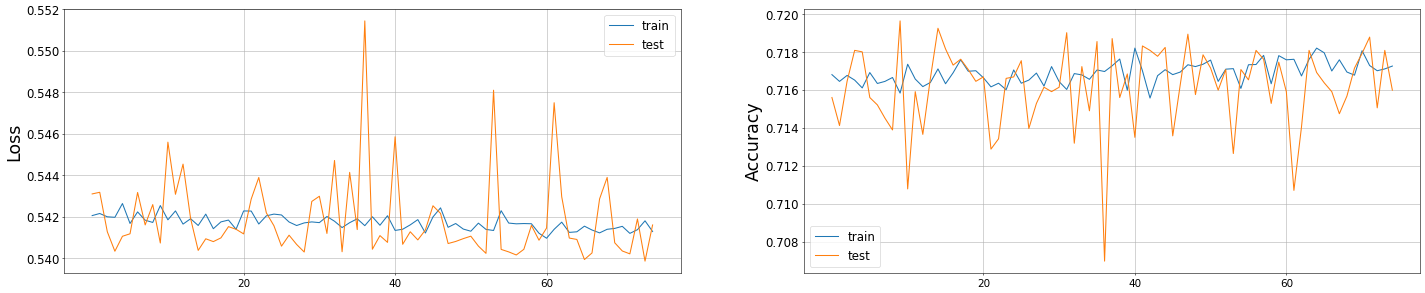

In [100]:
"""
looking at the train/test loss and accuracy over the epochs
"""

width_in_inches = 35
height_in_inches = 7
dots_per_inch = 50

plt.figure(
    figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)

# PICK THE FOLD
fold = 5

# plot loss during training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['loss'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(loc='upper right', fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/meanencoding/train.png')

# plot accuracy during training
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['accuracy'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/meanencoding/test.png')

plt.show()

671/671 [==============================] - 1s 2ms/step


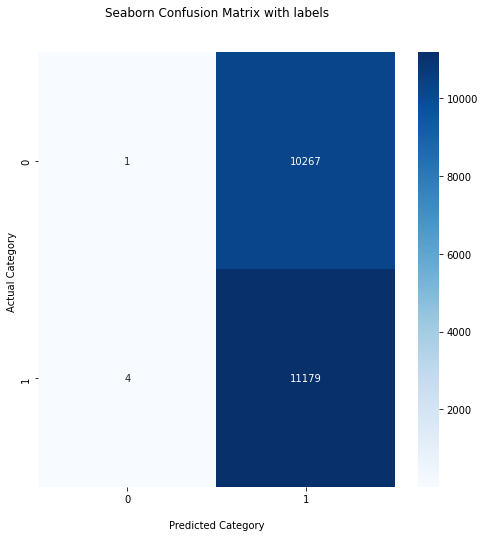

              precision    recall  f1-score   support

           0       0.20      0.00      0.00     10268
           1       0.52      1.00      0.69     11183

    accuracy                           0.52     21451
   macro avg       0.36      0.50      0.34     21451
weighted avg       0.37      0.52      0.36     21451



In [101]:
"""
printing the confusion matrix
"""

preds = load_model(filepath).predict(test_x).squeeze()

assert preds.shape == test_y.shape, 'The shapes of the two tensors are unequal'


cf_matrix = confusion_matrix(test_y, np.round(preds))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(test_y, np.round(preds)))

In [102]:
# Random Forest model
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
forest = RandomForestClassifier(max_depth=5)

# fit the model 
forest.fit(train_x, train_y)

#predicting the target value from the model for the samples
y_test_forest = forest.predict(test_x)

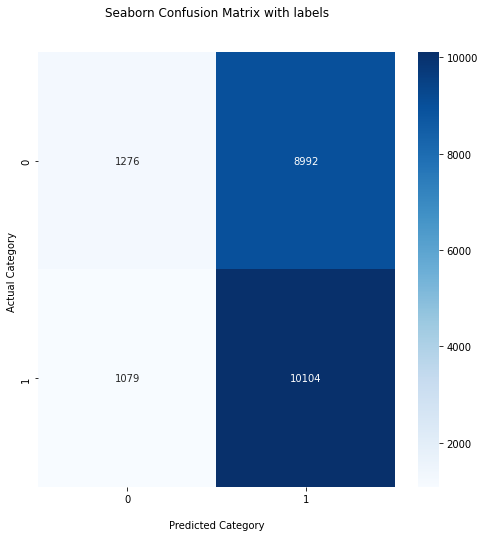

              precision    recall  f1-score   support

           0       0.12      0.54      0.20      2355
           1       0.90      0.53      0.67     19096

    accuracy                           0.53     21451
   macro avg       0.51      0.54      0.43     21451
weighted avg       0.82      0.53      0.62     21451



In [103]:

cf_matrix = confusion_matrix(test_y, y_test_forest)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(y_test_forest, test_y))

In [104]:
# Decision Tree model 
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth = 5)
# fit the model 
tree.fit(train_x, train_y)

#predicting the target value from the model for the samples
y_test_tree = tree.predict(test_x)

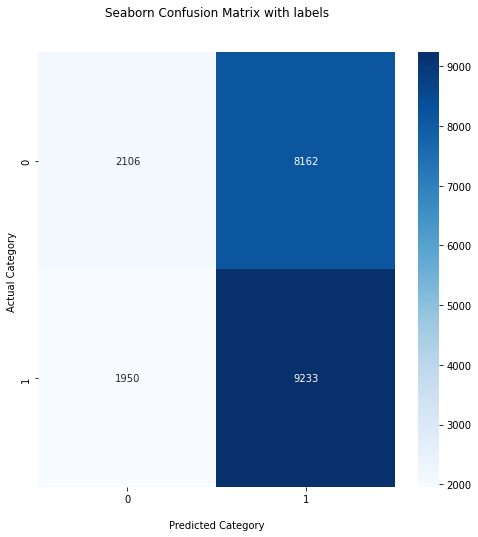

              precision    recall  f1-score   support

           0       0.21      0.52      0.29      4056
           1       0.83      0.53      0.65     17395

    accuracy                           0.53     21451
   macro avg       0.52      0.53      0.47     21451
weighted avg       0.71      0.53      0.58     21451



In [105]:

cf_matrix = confusion_matrix(test_y, y_test_tree)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(y_test_tree, test_y))

In [106]:
#XGBoost Classification model
from xgboost import XGBClassifier

# instantiate the model
xgb = XGBClassifier(learning_rate=0.4,max_depth=7)
#fit the model
xgb.fit(train_x, train_y)

#predicting the target value from the model for the samples
y_xgb = xgb.predict(test_x)

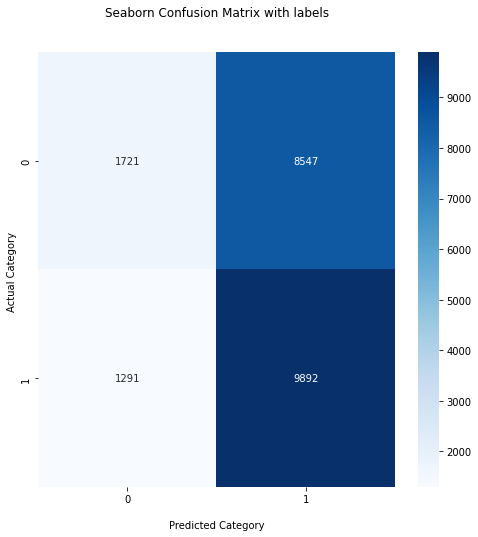

              precision    recall  f1-score   support

           0       0.17      0.57      0.26      3012
           1       0.88      0.54      0.67     18439

    accuracy                           0.54     21451
   macro avg       0.53      0.55      0.46     21451
weighted avg       0.78      0.54      0.61     21451



In [107]:

cf_matrix = confusion_matrix(test_y, y_xgb)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(y_xgb, test_y))


Test 4 - Data variation between dumpsites and non-dumpsites
Could be structured so as to change the 50/50 ratio between dumpsites and non-dumpsites dataset. Two possible variabtions to get started with

    More dumpsite data than non-dumpsite data - Reasoning could be that our model should be good at detecting dumpsites, hence it needs to learn what they look like.

    Less dumpsite than than non-dumpsite data - More closely related to what the data would probably look like in the real world.

Both variations need to be tested. However, first variation is more sensible on a preliminary logical approach (opinion) and should be given priority to tune.


In [108]:


# training data
final_bal = final.copy()

final_random_bal = final_random.copy()

# testing data
final_test_bal = final_test.copy()

final_random_test_bal = final_random_test.copy() 



In [109]:


final_bal.shape, final_random_bal.shape, final_test_bal.shape, final_random_test_bal.shape



((44841, 28), (44505, 28), (11207, 28), (11123, 28))

In [110]:


final_bal.head()



,TrashOutID,Lat,Lon,Distance to Minor Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,1stMostFreq,...,5thClosest,RoadDstBin,target,Africa,Asia,Australia,Europe,North America,Oceania,South America
0,57836,-26.182135,27.989881,47.383710,3553.60,0.317897,341,5,654.2,Bar,...,Bus Station,2.0,1,1,0,0,0,0,0,0
1,57831,-28.466159,28.855491,10.439037,1704.99,0.714321,1500,0,3000.0,None,...,None,2.0,1,1,0,0,0,0,0,0
2,57830,-28.514575,28.820169,0.000000,3842.15,0.494658,496,4,620.0,Auto Workshop,...,None,2.0,1,1,0,0,0,0,0,0
3,57829,-29.947538,30.915913,0.000000,11928.59,0.327302,61,1,61.0,Shopping Mall,...,None,2.0,1,1,0,0,0,0,0,0
4,57828,-26.243496,27.696129,16.189577,314.45,0.923777,1500,0,3000.0,None,...,None,0.0,1,1,0,0,0,0,0,0


In [111]:

#Reduce the size of the training random dumpsites dataset

final_random_bal = final_random_bal.sample(frac = 1.0)
final_bal = final_bal.sample(frac = 1.0)

print(final_bal.shape, final_random_bal.shape)
final_test_bal.shape, final_random_test_bal.shape



(44841, 28) (44505, 28)


((11207, 28), (11123, 28))

In [112]:
final_bal.head()

,TrashOutID,Lat,Lon,Distance to Minor Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,1stMostFreq,...,5thClosest,RoadDstBin,target,Africa,Asia,Australia,Europe,North America,Oceania,South America
32640,10791,52.290781,20.851923,43.928193,242.30,0.066401,358,4,603.500000,Grocery Store,...,None,2.0,1,0,0,0,1,0,0,0
10102,46081,48.346284,21.676901,813.464495,165.79,0.263539,977,1,977.000000,Pub,...,None,2.0,1,0,0,0,1,0,0,0
25832,21518,41.312794,19.813393,85.741785,12533.96,0.398720,206,78,728.948718,Hotel,...,Hotel,2.0,1,0,0,0,1,0,0,0
27918,18154,40.313028,20.190866,59.501024,12.01,0.574613,266,1,266.000000,Restaurant,...,None,1.0,1,0,0,0,1,0,0,0
3686,47731,-25.963500,32.566641,0.000000,7027.32,0.499951,169,20,705.500000,Fast Food Restaurant,...,Pizza Place,2.0,1,1,0,0,0,0,0,0


In [113]:
# combined data of dumpsites and non-dumpsites in train and test sets

data_bal = pd.concat([final_bal, final_random_bal], axis=0)

data_test_bal = pd.concat([final_test_bal, final_random_test_bal], axis=0)

In [114]:


data_bal.drop(['3rdMostFreq', '4thMostFreq', '5thMostFreq',
               '3rdClosest', '4thClosest', '5thClosest'], axis=1, inplace=True)
data_test_bal.drop(['3rdMostFreq', '4thMostFreq', '5thMostFreq',
               '3rdClosest', '4thClosest', '5thClosest'], axis=1, inplace=True)



In [115]:


data_bal.head()



,TrashOutID,Lat,Lon,Distance to Minor Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,1stMostFreq,...,2ndClosest,RoadDstBin,target,Africa,Asia,Australia,Europe,North America,Oceania,South America
32640,10791,52.290781,20.851923,43.928193,242.30,0.066401,358,4,603.500000,Grocery Store,...,Grocery Store,2.0,1,0,0,0,1,0,0,0
10102,46081,48.346284,21.676901,813.464495,165.79,0.263539,977,1,977.000000,Pub,...,None,2.0,1,0,0,0,1,0,0,0
25832,21518,41.312794,19.813393,85.741785,12533.96,0.398720,206,78,728.948718,Hotel,...,Dessert Shop,2.0,1,0,0,0,1,0,0,0
27918,18154,40.313028,20.190866,59.501024,12.01,0.574613,266,1,266.000000,Restaurant,...,None,1.0,1,0,0,0,1,0,0,0
3686,47731,-25.963500,32.566641,0.000000,7027.32,0.499951,169,20,705.500000,Fast Food Restaurant,...,Fast Food Restaurant,2.0,1,1,0,0,0,0,0,0


In [116]:

#Encoding for venue categories

# Transform the Venue categories by picking an encoding below
"""
Applying an encoding onto the 10 different columns (#thMostFreq and #thClosest) categorical variables
"""

encoding = "LeaveOneOut" #param ["LeaveOneOut", "Frequency", "Mean"]

columns = ['1stMostFreq', '2ndMostFreq',
           '1stClosest', '2ndClosest']

if encoding.lower() == 'leaveoneout':
    for col in columns: 
        # training
        leaveoneoutenc = ce.LeaveOneOutEncoder(return_df=True)
        leaveoneoutenc.fit(X=data_bal[col], y=data_bal['target'])

        data_bal[col + 'leaveoneout_enc'] = leaveoneoutenc.transform(data_bal[col])
        data_bal.drop([col], axis=1, inplace=True)
        
        #testing
        data_test_bal[col + 'leaveoneout_enc'] = leaveoneoutenc.transform(data_test_bal[col])
        data_test_bal.drop([col], axis=1, inplace=True)
        data_test_bal.head()

    data_bal.drop(['TrashOutID', 'Lat', 'Lon'], axis=1, inplace=True)
    data_test_bal.drop(['TrashOutID', 'Lat', 'Lon'], axis=1, inplace=True)

elif encoding.lower() == 'frequency':
    for col in columns:
        freq = data_bal.groupby(col).size() / len(data_bal)
        # training
        data_bal[col + 'frequency_enc'] = data_bal[col].map(freq)
        data_bal.drop([col], axis=1, inplace=True)
        
        #testing
        data_test_bal[col + 'frequency_enc'] = data_test_bal[col].map(freq)
        data_test_bal.drop([col], axis=1, inplace=True)

    data_bal.drop(['TrashOutID', 'Lat', 'Lon'], axis=1, inplace=True)
    data_test_bal.drop(['TrashOutID', 'Lat', 'Lon'], axis=1, inplace=True)

elif encoding.lower() == 'mean':
        class MultiColumnEncoder:
            def __init__(self, columns=None):
                self.columns = columns # array of column names to encode

            def fit_transform(self, X, test_set):
                mean = X['target'].mean()
                if self.columns is not None:
                    for col in self.columns:
                        agg= X.groupby(col)['target'].agg(['count','mean'])
                        counts=agg['count']
                        means=agg['mean']
                        weight=100
                        smooth = (counts*means +weight *mean) / (counts + weight)
                        X.loc[:, col+'_mean'] = X[col].map(smooth)
                        test_set.loc[:, col+'_mean'] = test_set[col].map(smooth)
                X.drop(self.columns,axis=1,inplace=True)
                test_set.drop(self.columns,axis=1,inplace=True)
                return X
        mc_class = MultiColumnEncoder(columns)
        data_bal = mc_class.fit_transform(data_bal, data_test_bal)
        data_bal.drop(['Lat', 'Lon', 'TrashOutID'], axis=1, inplace=True)
        data_test_bal.drop(['Lat', 'Lon', 'TrashOutID'], axis=1, inplace=True)



In [117]:


data_bal.head()



,Distance to Minor Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,RoadDstBin,target,Africa,Asia,Australia,Europe,North America,Oceania,South America,1stMostFreqleaveoneout_enc,2ndMostFreqleaveoneout_enc,1stClosestleaveoneout_enc,2ndClosestleaveoneout_enc
32640,43.928193,242.30,0.066401,358,4,603.500000,2.0,1,0,0,0,1,0,0,0,0.299299,0.499474,0.606965,0.536026
10102,813.464495,165.79,0.263539,977,1,977.000000,2.0,1,0,0,0,1,0,0,0,0.527653,0.465392,0.506083,0.465037
25832,85.741785,12533.96,0.398720,206,78,728.948718,2.0,1,0,0,0,1,0,0,0,0.549167,0.459480,0.548936,0.550000
27918,59.501024,12.01,0.574613,266,1,266.000000,1.0,1,0,0,0,1,0,0,0,0.555850,0.465392,0.532854,0.465037
3686,0.000000,7027.32,0.499951,169,20,705.500000,2.0,1,1,0,0,0,0,0,0,0.611182,0.731419,0.678571,0.594030


In [118]:
## Removing NaN values
"""
removing any null values in other variables
"""

print(data_bal.shape, data_test_bal.shape)

data_bal.dropna(inplace=True)
data_test_bal.dropna(inplace=True)

data_bal.shape, data_test_bal.shape

(89346, 19) (22330, 19)


((85790, 19), (21451, 19))

In [119]:

#Build the model

"""
training and testing separation
"""

X = data_bal.drop(['target'], axis=1).to_numpy()
Y = data_bal['target'].to_numpy()

test_x = data_test_bal.drop(['target'], axis=1).to_numpy()
test_y = data_test_bal['target'].to_numpy()

using_kfold = False

if not using_kfold:
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    stratify=Y,
                                                    random_state=111)
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")

else:
  X_train = X
  Y_train = Y
  print(f"X_train is {X_train.shape}", f"Y_train is {Y_train.shape}")



X_train is (68632, 18) X_test is (17158, 18)


In [120]:
"""
normalizing the continuous variables
"""

scaler = StandardScaler()

scaler.fit(X_train[:, :6])

X_train[:, :6] = scaler.transform(X_train[:, :6])

if not using_kfold:
  X_test[:, :6] = scaler.transform(X_test[:, :6]) 
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")
else:
  X_train.shape

X_train is (68632, 18) X_test is (17158, 18)


In [121]:
"""
building the model
"""

x_input = Input(shape=(X_train.shape[-1],), name='continuous_input')

x = Dense(units=16, activation='relu', name=f'dense_1',
          kernel_regularizer=regularizers.l2(1e-3),
          activity_regularizer=regularizers.l2(1e-3))(x_input)

# x = BatchNormalization(name=f'batchnorm_1')(x)
x = Dropout(rate=0.5, name=f'dropout_1')(x)

for i, unit in enumerate([16], start=2):
    x = Dense(units=unit, activation='relu', name=f'dense_{i}',
              kernel_regularizer=regularizers.l2(1e-3),
              activity_regularizer=regularizers.l2(1e-3))(x)
    
    # x = BatchNormalization(name=f'batchnorm_{i}')(x)
    x = Dropout(rate=0.5, name=f'dropout_{i}')(x)

out = Dense(units=1, activation='sigmoid', name='output_layer')(x)

model = Model(inputs=x_input, outputs=out, name='Dumpsite_Prediction_Model')

# saving the model graph and seeing the architecture 
plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/Official folder for Trashout/Task_1/models_final_model_nn_graph.png')

model.summary()

Model: "Dumpsite_Prediction_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 continuous_input (InputLaye  [(None, 18)]             0         
 r)                                                              
                                                                 
 dense_1 (Dense)             (None, 16)                304       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 17        
                                         

In [122]:

#Using K-Fold for better learning

"""
using the sklearn library to split the training data
into folds of training and validation splits
"""

n_split=10

fold = StratifiedShuffleSplit(n_splits=n_split, test_size=0.15,
                               random_state=111)

train_acc=[]
train_loss=[]
val_acc=[]
val_loss=[]

fold.get_n_splits(X_train, Y_train)



10

In [123]:

#Training

"""
compiling and fitting
"""

filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/pedro/final_model/curr_model.h5'

checkpoint = ModelCheckpoint(filepath=filepath_curr, monitor='val_accuracy', save_best_only=True)

opts = Adam(learning_rate=0.001, epsilon=1e-8, decay=0.000005)

# model will begin training with previously trained weights
try:
    model.load_weights(filepath_curr)
    print('Same architecture as before.\n\n')
except:
    print('Model architecture has been changed. No weights loaded.\n\n')

i = 1 # counter for print statement

if not using_kfold:
  model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(
      X_train,
      Y_train,
      batch_size=128,
      epochs=100,
      validation_data=(X_test, Y_test),
      callbacks=[checkpoint],
      verbose=2
  )
else:
  for train_index, val_index in fold.split(X_train, Y_train):

      train_x, val_x = X_train[train_index], X_train[val_index]
      train_y, val_y = Y_train[train_index], Y_train[val_index]

      model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
          
      history = model.fit(
          train_x,
          train_y,
          batch_size=128,
          epochs=75,
          validation_data=(val_x, val_y),
          callbacks=[checkpoint],
          verbose=0
      )

      curr_train_acc = round(model.evaluate(train_x, train_y, verbose=0)[1]*100, 2)
      curr_val_acc = round(model.evaluate(val_x, val_y, verbose=0)[1]*100, 2)

      curr_train_loss = model.evaluate(train_x, train_y, verbose=0)[0]
      curr_val_loss = model.evaluate(val_x, val_y, verbose=0)[0]

      print("-"*75)
      print(f"Fold {i}: train acc = {curr_train_acc}%")
      print(f"Fold {i}: val acc = {curr_val_acc}%")
      print("-"*75 + "\n\n")

      train_acc.append(curr_train_acc)
      val_acc.append(curr_val_acc)
      train_loss.append(curr_train_loss)
      val_loss.append(curr_val_loss)

      i += 1



Same architecture as before.


Epoch 1/100
537/537 - 2s - loss: 0.6160 - accuracy: 0.6614 - val_loss: 0.5886 - val_accuracy: 0.6846 - 2s/epoch - 4ms/step
Epoch 2/100
537/537 - 1s - loss: 0.6159 - accuracy: 0.6605 - val_loss: 0.5911 - val_accuracy: 0.6911 - 1s/epoch - 2ms/step
Epoch 3/100
537/537 - 1s - loss: 0.6157 - accuracy: 0.6623 - val_loss: 0.5915 - val_accuracy: 0.6910 - 1s/epoch - 2ms/step
Epoch 4/100
537/537 - 1s - loss: 0.6164 - accuracy: 0.6618 - val_loss: 0.5900 - val_accuracy: 0.6832 - 1s/epoch - 2ms/step
Epoch 5/100
537/537 - 1s - loss: 0.6154 - accuracy: 0.6634 - val_loss: 0.5926 - val_accuracy: 0.6931 - 1s/epoch - 2ms/step
Epoch 6/100
537/537 - 1s - loss: 0.6165 - accuracy: 0.6626 - val_loss: 0.5902 - val_accuracy: 0.6909 - 1s/epoch - 2ms/step
Epoch 7/100
537/537 - 1s - loss: 0.6159 - accuracy: 0.6629 - val_loss: 0.5897 - val_accuracy: 0.6924 - 1s/epoch - 2ms/step
Epoch 8/100
537/537 - 1s - loss: 0.6138 - accuracy: 0.6661 - val_loss: 0.5903 - val_accuracy: 0.6878 - 1s/ep

In [124]:

#Evaluating average accuracy and loss after K-Fold

if using_kfold:
  for i, v in enumerate(train_acc, start=0):
    print('-'*50)
    print(f'Fold {i+1} - Train Loss: {train_loss[i]} - Train Accuracy: {train_acc[i]}%')
    print(f'Fold {i+1} - Validation Loss: {val_loss[i]} - Validation Accuracy: {val_acc[i]}%')

  print('-'*50)

  print('\n\nAverage scores for all folds:\n\n')
  # training
  print(f'Train Accuracy: {round(np.mean(train_acc), 2)} +- {round(np.std(train_acc), 2)}')
  print(f'Train Loss: {round(np.mean(train_loss), 3)}')
  # validation
  print(f'\n\nTest Accuracy: {round(np.mean(val_acc), 2)} +- {round(np.std(val_acc), 2)}')
  print(f'Test Loss: {round(np.mean(val_loss), 3)}')



In [125]:
"""
this code takes care of saving the new model only if its accuracy is better than
that of the last model
"""

filepath = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/pedro/final_model/best_model.h5'
filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/pedro/final_model/curr_model.h5'


if os.path.exists(filepath):
  prev_model = load_model(filepath)
  curr_model = load_model(filepath_curr)

  prev_acc = prev_model.evaluate(test_x, test_y, verbose=0)[1]
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]

  if curr_acc > prev_acc:
    print("There was a previous model saved.\n")
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    curr_model.save(filepath)
    print('\nNew model is saved.')
  else:
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    print('Old model is kept.')

else: # if this is the first time saving the model
  model.save(filepath)
  curr_model = load_model(filepath)
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]
  print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
  print('\nFirst time model is saved.')

Previous test accuracy: 52.13%
Current test accuracy: 51.13%
Old model is kept.


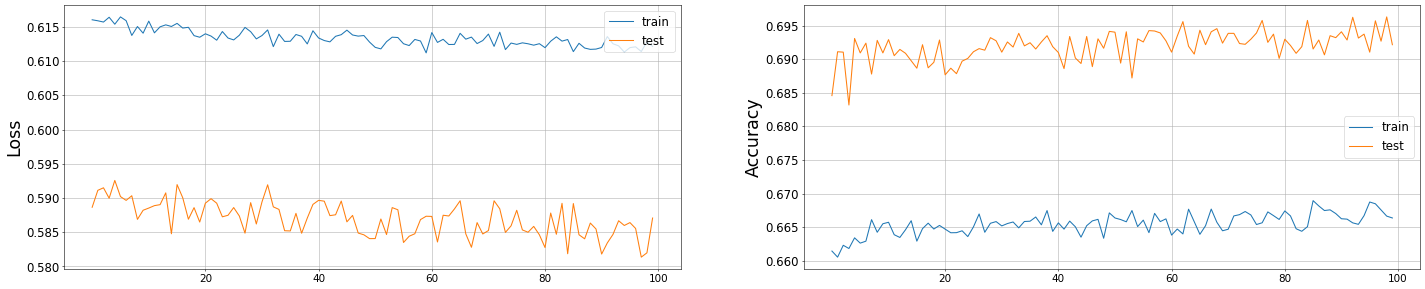

In [140]:
"""
looking at the train/test loss and accuracy over the epochs
"""

width_in_inches = 35
height_in_inches = 7
dots_per_inch = 50

plt.figure(
    figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)

# PICK THE FOLD
fold = 5

# plot loss during training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['loss'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(loc='upper right', fontsize=17)
plt.grid()
plt.savefig('/content/Illegal_dumpsites _data/train.png')

# plot accuracy during training
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['accuracy'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(fontsize=17)
plt.grid()
plt.savefig('/content/Illegal_dumpsites _data/test.png')

plt.show()

671/671 [==============================] - 1s 1ms/step


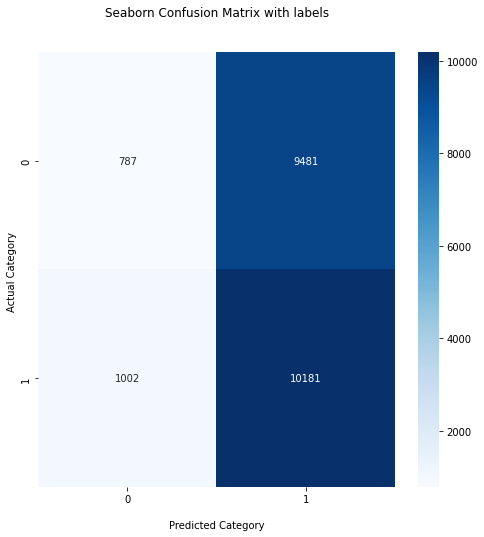

              precision    recall  f1-score   support

           0       0.44      0.08      0.13     10268
           1       0.52      0.91      0.66     11183

    accuracy                           0.51     21451
   macro avg       0.48      0.49      0.40     21451
weighted avg       0.48      0.51      0.41     21451



In [141]:
"""
printing the confusion matrix
"""

preds = load_model(filepath_curr).predict(test_x).squeeze()
np.expand_dims(test_y, axis=1)

threshold = 0.5
preds[preds >= threshold] = 1
preds[preds < threshold] = 0

assert preds.shape == test_y.shape, 'The shapes of the two tensors are unequal'

cf_matrix = confusion_matrix(test_y, preds)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(test_y, np.round(preds)))

In [142]:


preds = load_model(filepath_curr).predict(test_x).squeeze()
t = 0.0
print('in testy', len(test_y[test_y==0]), len(test_y[test_y==1]))
print('\n\n')
while t < 1.1:
  print(t, len(preds[preds < t]), len(preds[preds >= t]))
  t += 0.1



671/671 [==============================] - 1s 1ms/step
in testy 10268 11183



0.0 0 21451
0.1 1763 19688
0.2 1775 19676
0.30000000000000004 1781 19670
0.4 1785 19666
0.5 1789 19662
0.6 1799 19652
0.7 1807 19644
0.7999999999999999 1811 19640
0.8999999999999999 1821 19630
0.9999999999999999 2244 19207
1.0999999999999999 21451 0


In [143]:
# Random Forest model
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
forest = RandomForestClassifier(max_depth=5)

# fit the model 
forest.fit(X_train, Y_train)

#predicting the target value from the model for the samples
y_test_forest = forest.predict(test_x)

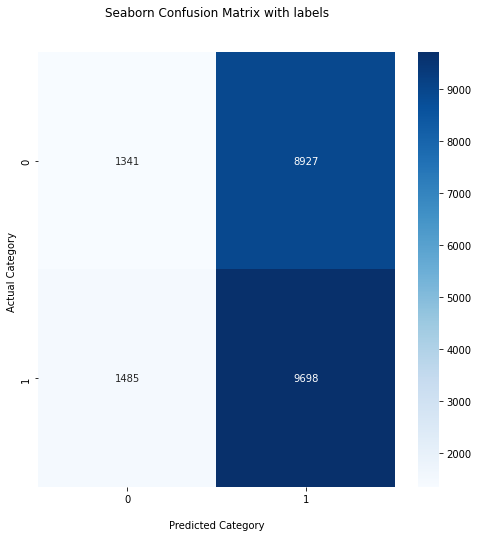

              precision    recall  f1-score   support

           0       0.13      0.47      0.20      2826
           1       0.87      0.52      0.65     18625

    accuracy                           0.51     21451
   macro avg       0.50      0.50      0.43     21451
weighted avg       0.77      0.51      0.59     21451



In [144]:

cf_matrix = confusion_matrix(test_y, y_test_forest)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()
print(classification_report(y_test_forest, test_y))

In [145]:
# Decision Tree model 
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth = 5)
# fit the model 
tree.fit(X_train, Y_train)

#predicting the target value from the model for the samples
y_test_tree = tree.predict(test_x)

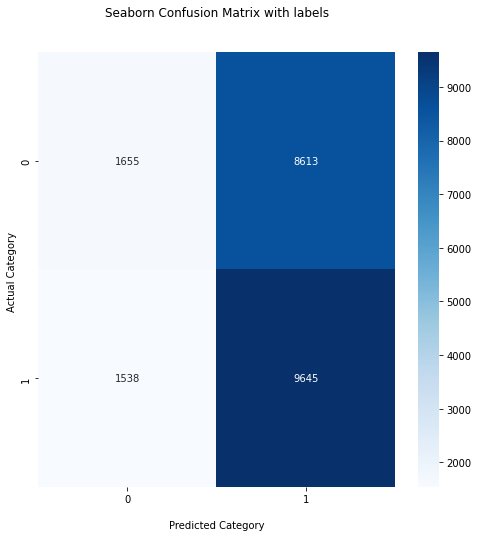

              precision    recall  f1-score   support

           0       0.16      0.52      0.25      3193
           1       0.86      0.53      0.66     18258

    accuracy                           0.53     21451
   macro avg       0.51      0.52      0.45     21451
weighted avg       0.76      0.53      0.59     21451



In [146]:

cf_matrix = confusion_matrix(test_y, y_test_tree)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()
print(classification_report(y_test_tree, test_y))

In [147]:
#XGBoost Classification model
from xgboost import XGBClassifier

# instantiate the model
xgb = XGBClassifier(learning_rate=0.4,max_depth=7)
#fit the model
xgb.fit(X_train, Y_train)

#predicting the target value from the model for the samples
y_xgb = xgb.predict(test_x)

[[2001 2513]
 [8267 8670]]


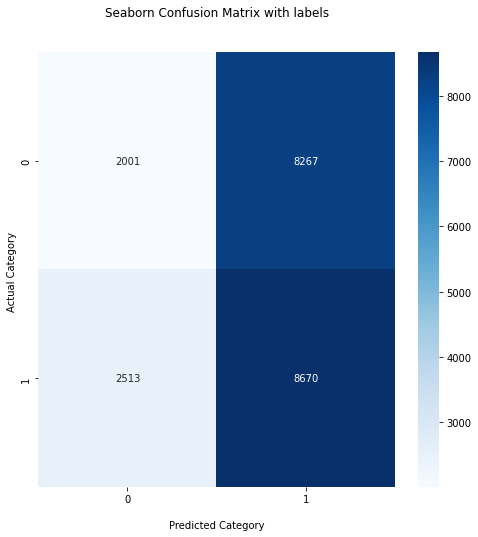

              precision    recall  f1-score   support

           0       0.19      0.44      0.27      4514
           1       0.78      0.51      0.62     16937

    accuracy                           0.50     21451
   macro avg       0.49      0.48      0.44     21451
weighted avg       0.65      0.50      0.54     21451



In [148]:
print(confusion_matrix(y_xgb, test_y))
cf_matrix = confusion_matrix(test_y, y_xgb)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()

print(classification_report(y_xgb, test_y))